# Deep Learning


Actividad 1: Deep Vision

# Estrategia 1: Red pre-entrenada VGG19

Para obtener la solución final, se siguen los siguientes pasos:

  1. En primer lugar, se obtienen los resultados tras aplicar TRANSFER LEARNING con la red MobileNetV2
  2. Se aplicará FINE TUNING
  3. Se valorará modificar la estructura del TOP MODEL (capas convolucionales y número de neuronas)
  4. Se valorarán distintas técnicas de regularización (weight regularization, dropout y batch normalization)
  5. Se aplicará DATA AUGMENTATION

## **1. TRANSFER LEARNING CON DISTINTAS REDES**

#### **Creando el top model y congelando TODAS las capas convolucionales (TRANSFER LEARNING) + Entrenamiento (35% Accuracy)**

In [ ]:
# conectarlo a nueva parte densa
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.applications import VGG19

base_model = VGG19(weights='imagenet',
                 include_top=False, # No incluir el Top Model (parte destinada a la clasificación)
                 input_shape=(32,32,3))
base_model.summary()

base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(512, activation='relu'))
pre_trained_model.add(layers.Dense(100, activation='softmax'))

pre_trained_model.summary()

80134624/80134624 [==============================] - 5s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

[INFO]: Loading CIFAR-100 data...
169001437/169001437 [==============================] - 15s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                         

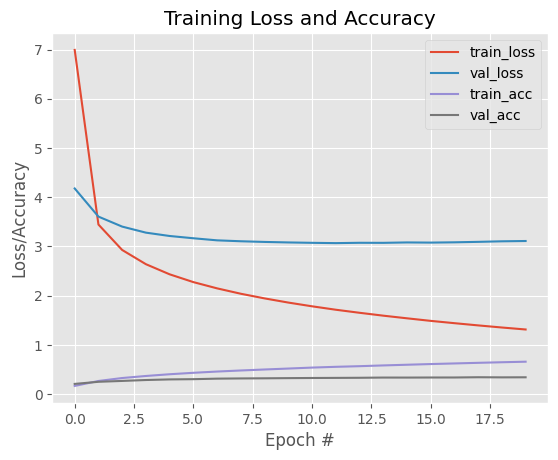

In [ ]:
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import vgg19
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from google.colab import drive

BASE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/DSC_Deep_Vision/modelos' # Ajustar el directorio raíz de Google Drive

# Carga de datos
print("[INFO]: Loading CIFAR-100 data...")
((x_train, y_train), (x_test, y_test)) = cifar100.load_data()

# CIFAR100 labelnames
labelNames = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# Pasamos las etiquetas a One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Normalizamos los datos
x_train = vgg19.preprocess_input(x_train)
x_test = vgg19.preprocess_input(x_test)

base_model = VGG19(weights='imagenet',
                 include_top=False, # No incluir el Top Model (parte destinada a la clasificación)
                 input_shape=(32,32,3))
base_model.summary()

# conectarlo a nueva parte densa
base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(512, activation='relu'))
pre_trained_model.add(layers.Dense(100, activation='softmax'))

pre_trained_model.summary()

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
pre_trained_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_pre = pre_trained_model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.2)

# Montamos la unidad de Drive
# drive.mount('/content/drive')
# Almacenamos el modelo empleando la función mdoel.save de Keras
# pre_trained_model.save(BASE_FOLDER+"deepCNN_CIFAR100_pretrained.h5")

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")

# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = pre_trained_model.predict(x_test, batch_size=256)

# Sacamos el report para test
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H_pre.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H_pre.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H_pre.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H_pre.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

## **2. FINE TUNING (ligera mejoría)**

#### **Descongelamos última capa convolucional (39% Accuracy)**

[INFO]: Loading CIFAR-100 data...
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)

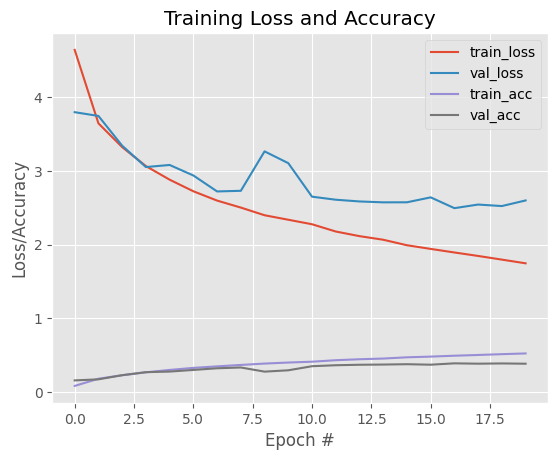

In [ ]:
# Imports que vamos a necesitar
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import vgg19, VGG19
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

BASE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/DSC_Deep_Vision/modelos' # Ajustar el directorio raíz de Google Drive

# Carga de datos
print("[INFO]: Loading CIFAR-100 data...")
((x_train, y_train), (x_test, y_test)) = cifar100.load_data()

# CIFAR100 labelnames
input_shape = (32, 32, 3)
labelNames = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# Pasamos las etiquetas a One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Normalizamos los datos
x_train = vgg19.preprocess_input(x_train)
x_test = vgg19.preprocess_input(x_test)

# Importamos VGG19 con pesos de imagenet y sin Top Model especificando tamaño de entrada de datos
base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Mostramos la arquitectura
base_model.summary()

# Congelamos las capas de los 4 primeros bloques convolucionales, el quinto se re-entrena
# Por defecto todas las capas estás a layer.trainable = True (entrenables)
# En base_model.layers.name tenemos la información del nombre de la capa
for layer in base_model.layers:
  if layer.name == 'block5_conv4':
    break
  layer.trainable = False
  print('Capa ' + layer.name + ' congelada...')

# Añadimos nuestro clasificador (Top Model)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(1024, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', name='fc2')(x)
x = Dense(100, activation='softmax', name='predictions')(x)
model = Model(base_model.input, x)

# Compilamos el modelo
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Vamos a visualizar el modelo prestando especial atención en el número de pesos total y el número de pesos entrenables.
model.summary()

# Entrenamos el modelo
H = model.fit(x_train, y_train, validation_split=0.2, batch_size=256, epochs=20, verbose=1)

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")
predictions = model.predict(x_test, batch_size=64)

# Obtener el report de clasificación
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


#### **Descongelamos 2 últimas capas convolucionales (39% Accuracy)**

[INFO]: Loading CIFAR-100 data...
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)

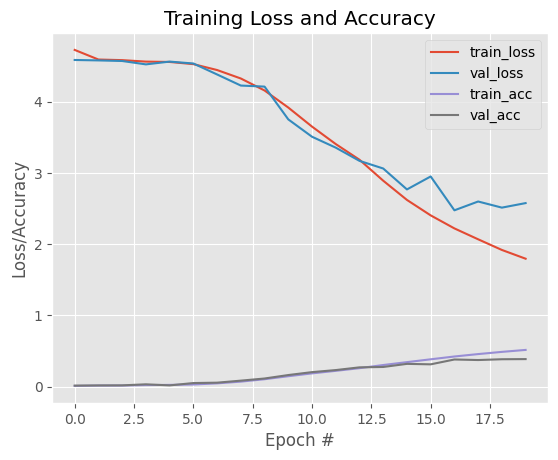

In [ ]:
# Imports que vamos a necesitar
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import vgg19, VGG19
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

BASE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/DSC_Deep_Vision/modelos' # Ajustar el directorio raíz de Google Drive

# Carga de datos
print("[INFO]: Loading CIFAR-100 data...")
((x_train, y_train), (x_test, y_test)) = cifar100.load_data()

# CIFAR100 labelnames
input_shape = (32, 32, 3)
labelNames = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# Pasamos las etiquetas a One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Normalizamos los datos
x_train = vgg19.preprocess_input(x_train)
x_test = vgg19.preprocess_input(x_test)

# Importamos VGG19 con pesos de imagenet y sin Top Model especificando tamaño de entrada de datos
base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Mostramos la arquitectura
base_model.summary()

# Congelamos las capas de los 4 primeros bloques convolucionales, el quinto se re-entrena
# Por defecto todas las capas estás a layer.trainable = True (entrenables)
# En base_model.layers.name tenemos la información del nombre de la capa
for layer in base_model.layers:
  if layer.name == 'block5_conv3':
    break
  layer.trainable = False
  print('Capa ' + layer.name + ' congelada...')

# Añadimos nuestro clasificador (Top Model)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(1024, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', name='fc2')(x)
x = Dense(100, activation='softmax', name='predictions')(x)
model = Model(base_model.input, x)

# Compilamos el modelo
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Vamos a visualizar el modelo prestando especial atención en el número de pesos total y el número de pesos entrenables.
model.summary()

# Entrenamos el modelo
H = model.fit(x_train, y_train, validation_split=0.2, batch_size=256, epochs=20, verbose=1)

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")
predictions = model.predict(x_test, batch_size=64)

# Obtener el report de clasificación
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

#### **Descongelamos 7 últimas capas convolucionales (48% Accuracy)**

[INFO]: Loading CIFAR-100 data...
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)

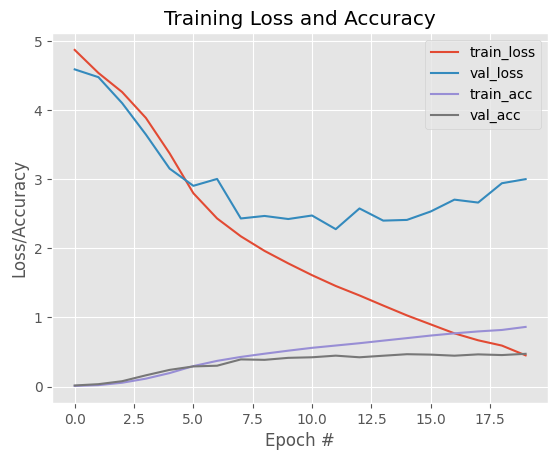

In [ ]:
# Imports que vamos a necesitar
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import vgg19, VGG19
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

BASE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/DSC_Deep_Vision/modelos' # Ajustar el directorio raíz de Google Drive

# Carga de datos
print("[INFO]: Loading CIFAR-100 data...")
((x_train, y_train), (x_test, y_test)) = cifar100.load_data()

# CIFAR100 labelnames
input_shape = (32, 32, 3)
labelNames = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# Pasamos las etiquetas a One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Normalizamos los datos
x_train = vgg19.preprocess_input(x_train)
x_test = vgg19.preprocess_input(x_test)

# Importamos VGG19 con pesos de imagenet y sin Top Model especificando tamaño de entrada de datos
base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Mostramos la arquitectura
base_model.summary()

# Congelamos las capas de los 4 primeros bloques convolucionales, el quinto se re-entrena
# Por defecto todas las capas estás a layer.trainable = True (entrenables)
# En base_model.layers.name tenemos la información del nombre de la capa
for layer in base_model.layers:
  if layer.name == 'block4_conv4':
    break
  layer.trainable = False
  print('Capa ' + layer.name + ' congelada...')

# Añadimos nuestro clasificador (Top Model)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(1024, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', name='fc2')(x)
x = Dense(100, activation='softmax', name='predictions')(x)
model = Model(base_model.input, x)

# Compilamos el modelo
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Vamos a visualizar el modelo prestando especial atención en el número de pesos total y el número de pesos entrenables.
model.summary()

# Entrenamos el modelo
H = model.fit(x_train, y_train, validation_split=0.2, batch_size=256, epochs=20, verbose=1)

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")
predictions = model.predict(x_test, batch_size=64)

# Obtener el report de clasificación
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### **Análisis de resultados**

Se consigue mejorar el rendimiento de la red aplicando Fine Tuning.

Con ello, se intrepreta que el dataset VGG19 tiene una buena semejanza con el dataset del problema.

Se ha conseguido aumentar ligeramante el accuracy con Fine Tunning. Se selecciona el modelo entrenado con Transfer Learning con la red VGG19 a la que se intentará ajustar el TOP MODEL, se aplicará Data Augmentation y se valorará ajustar el resto de parámetros de regularización para intentar mejorar el overfitting.

## **3. AJUSTE ESTRUCTURA TOP MODEL**

### **3.1. Primer intento (Ha empeorado)**

Se modifica la estructura del Top Model modificando la hidden layer a 256 neuronas.

[INFO]: Loading CIFAR-100 data...
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)

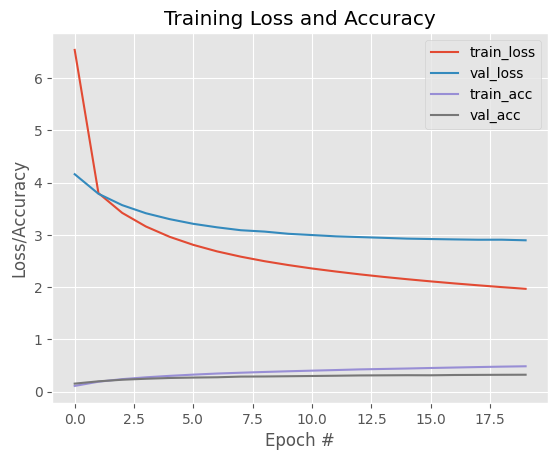

In [47]:
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import vgg19
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from google.colab import drive

BASE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/DSC_Deep_Vision/modelos' # Ajustar el directorio raíz de Google Drive

# Carga de datos
print("[INFO]: Loading CIFAR-100 data...")
((x_train, y_train), (x_test, y_test)) = cifar100.load_data()

# CIFAR100 labelnames
labelNames = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# Pasamos las etiquetas a One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Normalizamos los datos
x_train = vgg19.preprocess_input(x_train)
x_test = vgg19.preprocess_input(x_test)

base_model = VGG19(weights='imagenet',
                 include_top=False, # No incluir el Top Model (parte destinada a la clasificación)
                 input_shape=(32,32,3))
base_model.summary()

# conectarlo a nueva parte densa
base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(256, activation='relu'))
pre_trained_model.add(layers.Dense(100, activation='softmax'))

pre_trained_model.summary()

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
pre_trained_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_pre = pre_trained_model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.2)

# Montamos la unidad de Drive
# drive.mount('/content/drive')
# Almacenamos el modelo empleando la función mdoel.save de Keras
# pre_trained_model.save(BASE_FOLDER+"deepCNN_CIFAR100_pretrained.h5")

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")

# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = pre_trained_model.predict(x_test, batch_size=256)

# Sacamos el report para test
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H_pre.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H_pre.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H_pre.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H_pre.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

No se mejora ni el accuracy ni el overfitting.

### **3.2. Segundo intento (Algo mejor)**

Se crean dos hidden layers de 1024 y 256 neuronas en el Top Model.

[INFO]: Loading CIFAR-100 data...
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)

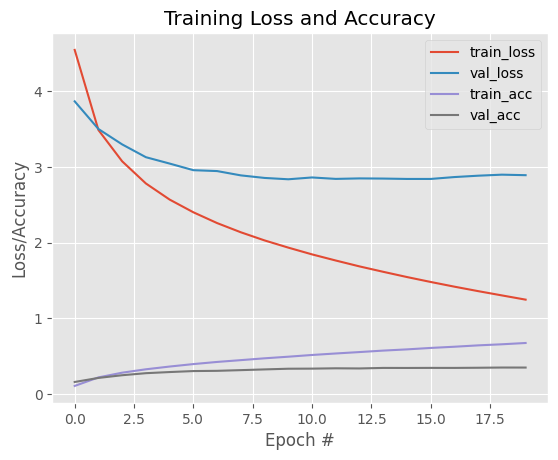

In [ ]:
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import vgg19
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from google.colab import drive

BASE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/DSC_Deep_Vision/modelos' # Ajustar el directorio raíz de Google Drive

# Carga de datos
print("[INFO]: Loading CIFAR-100 data...")
((x_train, y_train), (x_test, y_test)) = cifar100.load_data()

# CIFAR100 labelnames
labelNames = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# Pasamos las etiquetas a One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Normalizamos los datos
x_train = vgg19.preprocess_input(x_train)
x_test = vgg19.preprocess_input(x_test)

base_model = VGG19(weights='imagenet',
                 include_top=False, # No incluir el Top Model (parte destinada a la clasificación)
                 input_shape=(32,32,3))
base_model.summary()

# conectarlo a nueva parte densa
base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(1024, activation='relu'))
pre_trained_model.add(layers.Dense(256, activation='relu'))
pre_trained_model.add(layers.Dense(100, activation='softmax'))
pre_trained_model.summary()

pre_trained_model.summary()

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
pre_trained_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_pre = pre_trained_model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.2)

# Montamos la unidad de Drive
# drive.mount('/content/drive')
# Almacenamos el modelo empleando la función mdoel.save de Keras
# pre_trained_model.save(BASE_FOLDER+"deepCNN_CIFAR100_pretrained.h5")

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")

# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = pre_trained_model.predict(x_test, batch_size=256)

# Sacamos el report para test
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H_pre.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H_pre.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H_pre.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H_pre.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

Se aumenta en 500k los  parámetros, pero no se consigue mejorar ni el accuracy ni el overfitting. Se mantiene la arquitectura del 1º modelo entrenado, con la capa de 512 neuronas del Top Model.

## **4. AJUSTE PARÁMETROS DE REGULARIZACIÓN**

### **4.1. Weight regularization L2 (mejora respecto a la anterior)**

[INFO]: Loading CIFAR-100 data...
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)

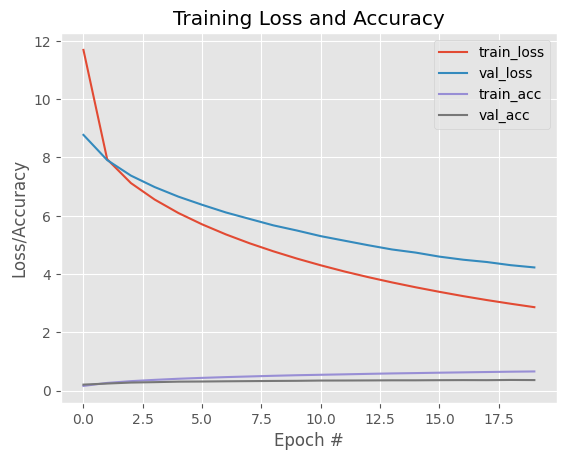

In [ ]:
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import vgg19
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from google.colab import drive

BASE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/DSC_Deep_Vision/modelos' # Ajustar el directorio raíz de Google Drive

# Carga de datos
print("[INFO]: Loading CIFAR-100 data...")
((x_train, y_train), (x_test, y_test)) = cifar100.load_data()

# CIFAR100 labelnames
labelNames = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# Pasamos las etiquetas a One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Normalizamos los datos
x_train = vgg19.preprocess_input(x_train)
x_test = vgg19.preprocess_input(x_test)

base_model = VGG19(weights='imagenet',
                 include_top=False, # No incluir el Top Model (parte destinada a la clasificación)
                 input_shape=(32,32,3))
base_model.summary()

# conectarlo a nueva parte densa
base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
pre_trained_model.add(layers.Dense(100, activation='softmax'))


pre_trained_model.summary()

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
pre_trained_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_pre = pre_trained_model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.2)

# Montamos la unidad de Drive
# drive.mount('/content/drive')
# Almacenamos el modelo empleando la función mdoel.save de Keras
# pre_trained_model.save(BASE_FOLDER+"deepCNN_CIFAR100_pretrained.h5")

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")

# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = pre_trained_model.predict(x_test, batch_size=256)

# Sacamos el report para test
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H_pre.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H_pre.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H_pre.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H_pre.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

Mejora muy ligeramente el overfitting

### **4.2. Dropout (Empeora)**

[INFO]: Loading CIFAR-100 data...
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)

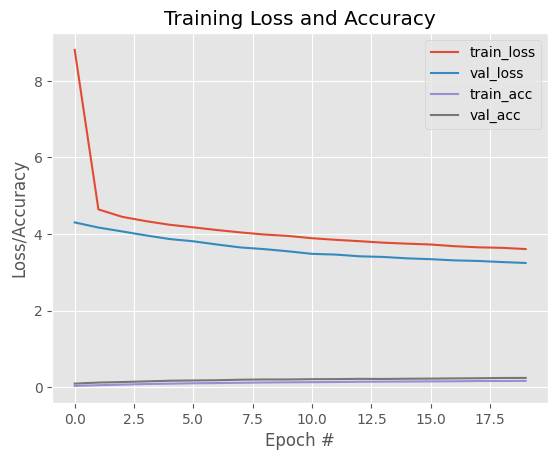

In [ ]:
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import vgg19
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from google.colab import drive

BASE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/DSC_Deep_Vision/modelos' # Ajustar el directorio raíz de Google Drive

# Carga de datos
print("[INFO]: Loading CIFAR-100 data...")
((x_train, y_train), (x_test, y_test)) = cifar100.load_data()

# CIFAR100 labelnames
labelNames = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# Pasamos las etiquetas a One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Normalizamos los datos
x_train = vgg19.preprocess_input(x_train)
x_test = vgg19.preprocess_input(x_test)

base_model = VGG19(weights='imagenet',
                 include_top=False, # No incluir el Top Model (parte destinada a la clasificación)
                 input_shape=(32,32,3))
base_model.summary()

# conectarlo a nueva parte densa
base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(512, activation='relu'))
pre_trained_model.add(Dropout(0.75))
pre_trained_model.add(layers.Dense(100, activation='softmax'))

pre_trained_model.summary()

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
pre_trained_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_pre = pre_trained_model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.2)

# Montamos la unidad de Drive
# drive.mount('/content/drive')
# Almacenamos el modelo empleando la función mdoel.save de Keras
# pre_trained_model.save(BASE_FOLDER+"deepCNN_CIFAR100_pretrained.h5")

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")

# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = pre_trained_model.predict(x_test, batch_size=256)

# Sacamos el report para test
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H_pre.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H_pre.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H_pre.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H_pre.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### **4.3. Batch normalization (ligera mejora)**

[INFO]: Loading CIFAR-100 data...
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)

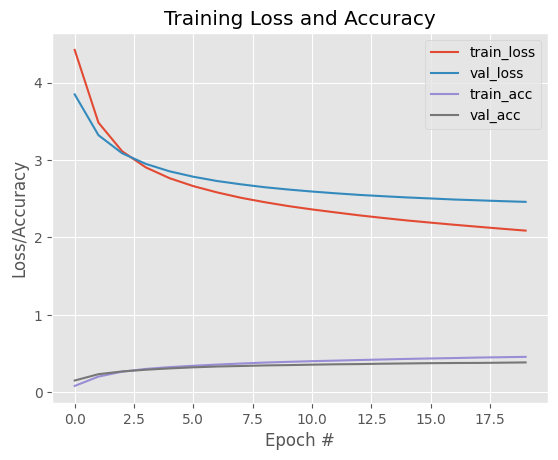

In [ ]:
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import vgg19
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from google.colab import drive

BASE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/DSC_Deep_Vision/modelos' # Ajustar el directorio raíz de Google Drive

# Carga de datos
print("[INFO]: Loading CIFAR-100 data...")
((x_train, y_train), (x_test, y_test)) = cifar100.load_data()

# CIFAR100 labelnames
labelNames = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# Pasamos las etiquetas a One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Normalizamos los datos
x_train = vgg19.preprocess_input(x_train)
x_test = vgg19.preprocess_input(x_test)

base_model = VGG19(weights='imagenet',
                 include_top=False, # No incluir el Top Model (parte destinada a la clasificación)
                 input_shape=(32,32,3))
base_model.summary()

# conectarlo a nueva parte densa
base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(512, activation='relu'))
pre_trained_model.add(BatchNormalization())
pre_trained_model.add(layers.Dense(100, activation='softmax'))

pre_trained_model.summary()

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
pre_trained_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_pre = pre_trained_model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.2)

# Montamos la unidad de Drive
# drive.mount('/content/drive')
# Almacenamos el modelo empleando la función mdoel.save de Keras
# pre_trained_model.save(BASE_FOLDER+"deepCNN_CIFAR100_pretrained.h5")

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")

# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = pre_trained_model.predict(x_test, batch_size=256)

# Sacamos el report para test
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H_pre.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H_pre.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H_pre.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H_pre.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### **4.4. Combinación de las 3 técnicas de regularización (sin mejoría respecto al fine tuning)**

[INFO]: Loading CIFAR-100 data...
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)

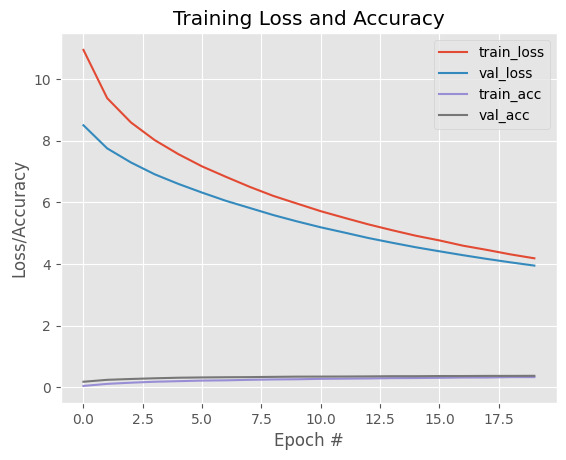

In [ ]:
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import vgg19
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from google.colab import drive

BASE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/DSC_Deep_Vision/modelos' # Ajustar el directorio raíz de Google Drive

# Carga de datos
print("[INFO]: Loading CIFAR-100 data...")
((x_train, y_train), (x_test, y_test)) = cifar100.load_data()

# CIFAR100 labelnames
labelNames = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# Pasamos las etiquetas a One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Normalizamos los datos
x_train = vgg19.preprocess_input(x_train)
x_test = vgg19.preprocess_input(x_test)

base_model = VGG19(weights='imagenet',
                 include_top=False, # No incluir el Top Model (parte destinada a la clasificación)
                 input_shape=(32,32,3))
base_model.summary()

# conectarlo a nueva parte densa
base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(512, activation='relu'))
pre_trained_model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
pre_trained_model.add(BatchNormalization())
pre_trained_model.add(Dropout(0.75))
pre_trained_model.add(layers.Dense(100, activation='softmax'))

pre_trained_model.summary()

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
pre_trained_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_pre = pre_trained_model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.2)

# Montamos la unidad de Drive
# drive.mount('/content/drive')
# Almacenamos el modelo empleando la función mdoel.save de Keras
# pre_trained_model.save(BASE_FOLDER+"deepCNN_CIFAR100_pretrained.h5")

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")

# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = pre_trained_model.predict(x_test, batch_size=256)

# Sacamos el report para test
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H_pre.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H_pre.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H_pre.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H_pre.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

No se aprecia una mejoría respecto a aplicar únicamente batch normalization.

## **5. DATA AUGMENTATION**

### **5.1. Inspeccionando las muestras generadas sintéticamente**

### **5.1.1.Importación y carga de datos**

In [1]:
from tensorflow.keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from re import X
from tensorflow import keras


# Pre-procesado obligatorio cuando trabajo con redes neuronales
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.backend import expand_dims

# Construccion de una red CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.metrics import classification_report
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report
from tensorflow.keras.applications import VGG16 #red que queramos usar, ejemplo vgg16, vgg19, ResNet50, Xception, InceptionV3, InceptionResNetV2, DenseNet, RasNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input


#Visualización de imagen
from tensorflow.keras.preprocessing.image import array_to_img
import time

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16964878741683452952
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14328594432
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14692141530818565350
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


### **5.1.2 Importación de cifar100 y Acondicionamiento del conjunto de datos**

In [2]:
def shapes(*x):
    for idx, item in enumerate(x):
        print(f"arg_{idx}: {item.shape}") if hasattr(item, "shape") else print(f"arg_{idx}: {len(item)}")

In [3]:
from keras.datasets import cifar100
from IPython.display import clear_output

(x_train, y_train_r), (x_test, y_test_r) = cifar100.load_data(label_mode='fine')
x_train, x_test = x_train/255, x_test/255
y_train, y_test = keras.utils.to_categorical(y_train_r, 100), keras.utils.to_categorical(y_test_r, 100)
clear_output()
# Mostrar la forma de los conjuntos de datos
print("Forma de los conjuntos de datos:")
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)
print("y_train_r:", y_train_r.shape)
print("y_test_r:", y_test_r.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Forma de los conjuntos de datos:
x_train: (50000, 32, 32, 3)
x_test: (10000, 32, 32, 3)
y_train_r: (50000, 1)
y_test_r: (10000, 1)
y_train: (50000, 100)
y_test: (10000, 100)


In [4]:
# CIFAR100 labelnames
labelNames = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']


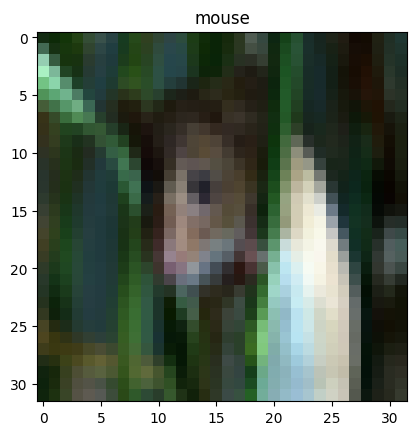

In [5]:
for i in np.random.permutation(len(x_train)-1)[:10]:
    plt.imshow(x_train[i])
    plt.title(labelNames[int(y_train_r[i])])
    plt.show()
    time.sleep(0.5)
    clear_output(wait=True)

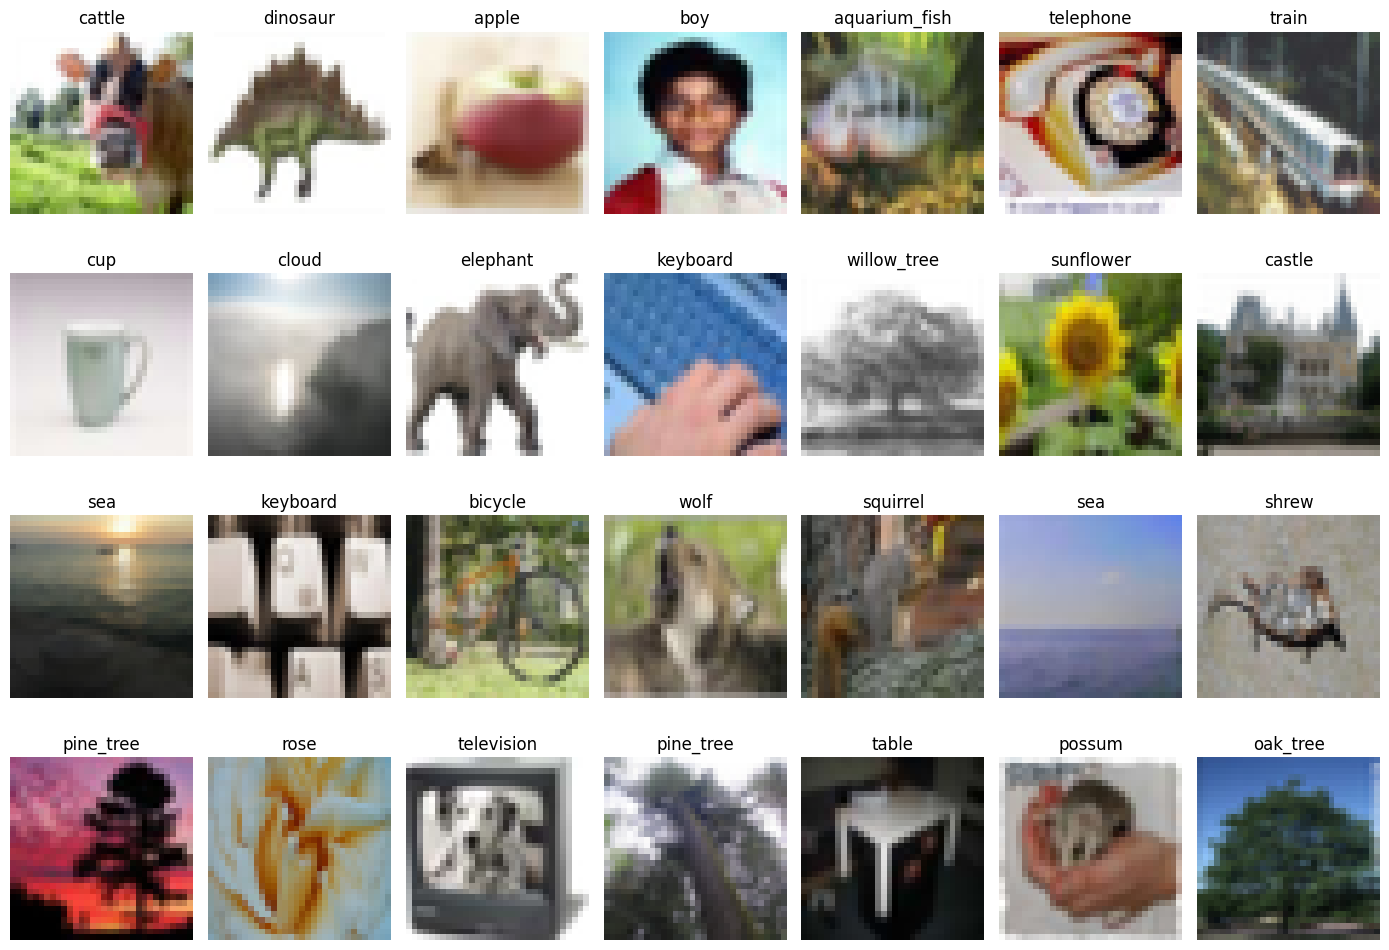

In [6]:
# Crear una figura y ejes de subtrama
fig, axes = plt.subplots(4, 7, figsize=(14, 10))
axes = axes.flatten()

# Mostrar las imágenes con etiquetas
for i in range(len(axes)):
    axes[i].imshow(x_train[i])
    axes[i].set_title(labelNames[y_train_r[i][0]])
    axes[i].axis('off')

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()

### **5.1.3. Creando un contenedor DataGenerator para el aumento automático de muestras**

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15, # grados de rotación aleatoria
    width_shift_range=0.1, # fracción del total (1) para mover la imagen
    height_shift_range=0.1, # fracción del total (1) para mover la imagen
    horizontal_flip=True, # girar las imágenes horizontalmente (eje vertical)
    # shear_range=0, # deslizamiento
    # zoom_range=0.1, # rango de zoom
    # fill_mode='nearest', # como rellenar posibles nuevos píxeles
    # channel_shift_range=0.2 # cambios aleatorios en los canales de la imagen

    ##################################################
    # (X) INPUT - Definir la partición de validación
    ##################################################
    validation_split=0.2
)

#### **5.1.4. Inspeccionando las muestras generadas sintéticamente**

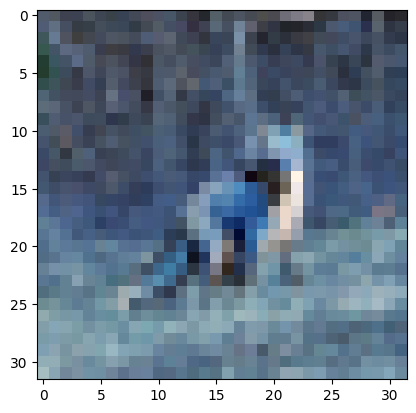

Label = fox


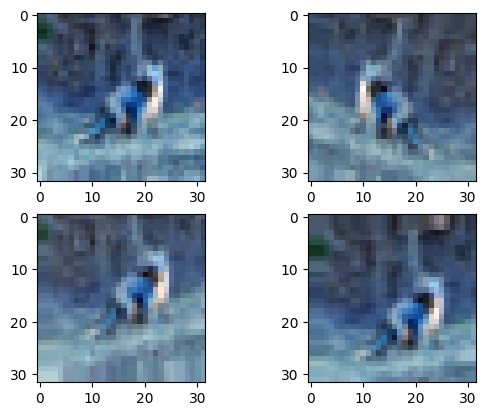

In [18]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

sample = 120
plt.imshow(image.array_to_img(x_train[sample]))
plt.show()
print('Label = {}'.format(labelNames[y_train[sample].argmax(axis=0)]))

fig, axes = plt.subplots(2,2)
i = 0
for batch in datagen.flow(x_train[sample].reshape((1,32,32,3)),batch_size=1):
    axes[i//2,i%2].imshow(image.array_to_img(batch[0]))
    i += 1
    if i == 4:
        break
plt.show()

### **5.2. Aplicando Data augmentation al modelo partiendo del modelo con un accuracy = 39%**

####   **5.2.1 Data augmentation con solo una muestra sintética por cada una real (empeora el accuracy)**

[INFO]: Loading CIFAR-100 data...
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)

ValueError: ignored

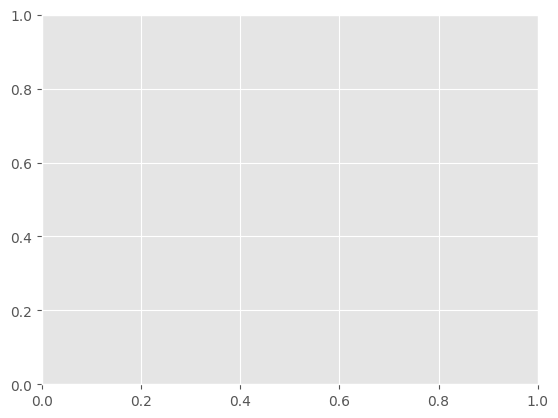

In [25]:
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import vgg19
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from google.colab import drive

BASE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/DSC_Deep_Vision/modelos' # Ajustar el directorio raíz de Google Drive

# Carga de datos
print("[INFO]: Loading CIFAR-100 data...")
((x_train, y_train), (x_test, y_test)) = cifar100.load_data()

# CIFAR100 labelnames
labelNames = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# Pasamos las etiquetas a One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Normalizamos los datos
x_train = vgg19.preprocess_input(x_train)
x_test = vgg19.preprocess_input(x_test)

base_model = VGG19(weights='imagenet',
                 include_top=False, # No incluir el Top Model (parte destinada a la clasificación)
                 input_shape=(32,32,3))
base_model.summary()

# conectarlo a nueva parte densa
# Definimos entradas
inputs = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(512, activation='relu'))
pre_trained_model.add(layers.Dense(100, activation='softmax'))

pre_trained_model.summary()

# Entrenando la solución con data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    ##################################################
    # (X) INPUT - Definir la partición de validation
    ##################################################
     validation_split=0.2
    )

data_aug_factor = 1 # Creación de 1 muestra sintética por cada mues tra real

train_generator = datagen.flow(
  x_train,
  y_train,
  batch_size=128,
  subset= "training"
  )

validation_generator = datagen.flow(
  x_train,
  y_train,
  batch_size=128,
  subset= "validation"
  )
# Compilar el modelo
print("[INFO]: Compilando el modelo...")
pre_trained_model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_aug = pre_trained_model.fit(
            train_generator,
            steps_per_epoch = train_generator.n*data_aug_factor//128,   # nº de muestras/batchsize
            validation_data = validation_generator,
            validation_steps = validation_generator.n*data_aug_factor//128,
            workers = data_aug_factor, # nº máximo de procesos en paralelo
            epochs = 50)
# Montamos la unidad de Drive
# drive.mount('/content/drive')
# Almacenamos el modelo empleando la función mdoel.save de Keras
# pre_trained_model.save(BASE_FOLDER+"deepCNN_CIFAR100_pretrained.h5")

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")

# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = pre_trained_model.predict(x_test, batch_size=256)

# Sacamos el report para test
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# Gráficas
'''
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H_aug.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H_aug.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H_aug.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H_aug.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()
'''

#### **5.2.2 Data augmentation con dos muestras sintéticas por cada una real (empeora el accuracy (88%))**

In [26]:
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import vgg19
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from google.colab import drive

BASE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/DSC_Deep_Vision/modelos' # Ajustar el directorio raíz de Google Drive

# Carga de datos
print("[INFO]: Loading CIFAR-100 data...")
((x_train, y_train), (x_test, y_test)) = cifar100.load_data()

# CIFAR100 labelnames
labelNames = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# Pasamos las etiquetas a One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Normalizamos los datos
x_train = vgg19.preprocess_input(x_train)
x_test = vgg19.preprocess_input(x_test)

base_model = VGG19(weights='imagenet',
                 include_top=False, # No incluir el Top Model (parte destinada a la clasificación)
                 input_shape=(32,32,3))
base_model.summary()

# conectarlo a nueva parte densa
# Definimos entradas
inputs = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(512, activation='relu'))
pre_trained_model.add(layers.Dense(100, activation='softmax'))

pre_trained_model.summary()

# Entrenando la solución con data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    ##################################################
    # (X) INPUT - Definir la partición de validation
    ##################################################
     validation_split=0.2
    )

data_aug_factor = 2 # Creación de 1 muestra sintética por cada mues tra real

train_generator = datagen.flow(
  x_train,
  y_train,
  batch_size=128,
  subset= "training"
  )

validation_generator = datagen.flow(
  x_train,
  y_train,
  batch_size=128,
  subset= "validation"
  )
# Compilar el modelo
print("[INFO]: Compilando el modelo...")
pre_trained_model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_aug = pre_trained_model.fit(
            train_generator,
            steps_per_epoch = train_generator.n*data_aug_factor//128,   # nº de muestras/batchsize
            validation_data = validation_generator,
            validation_steps = validation_generator.n*data_aug_factor//128,
            workers = data_aug_factor, # nº máximo de procesos en paralelo
            epochs = 50)
# Montamos la unidad de Drive
# drive.mount('/content/drive')
# Almacenamos el modelo empleando la función mdoel.save de Keras
# pre_trained_model.save(BASE_FOLDER+"deepCNN_CIFAR100_pretrained.h5")

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")

# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = pre_trained_model.predict(x_test, batch_size=256)

# Sacamos el report para test
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

[INFO]: Loading CIFAR-100 data...
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)

# Estrategia 1: Red pre-entrenada ResNet50

Para obtener la solución final, se siguen los siguientes pasos:

  1. En primer lugar, se obtienen los resultados tras aplicar TRANSFER LEARNING con la red MobileNetV2
  2. Se aplicará FINE TUNING
  3. Se valorará modificar la estructura del TOP MODEL (capas convolucionales y número de neuronas)
  4. Se valorarán distintas técnicas de regularización (weight regularization, dropout y batch normalization)
  5. Se aplicará DATA AUGMENTATION

## **1. TRANSFER LEARNING CON DISTINTAS REDES**

#### **Creando el top model y congelando TODAS las capas convolucionales (TRANSFER LEARNING) + Entrenamiento (40% Accuracy, mejor que con la red VGG19**

In [27]:
# conectarlo a nueva parte densa
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet',
                 include_top=False, # No incluir el Top Model (parte destinada a la clasificación)
                 input_shape=(32,32,3))
base_model.summary()

base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(512, activation='relu'))
pre_trained_model.add(layers.Dense(100, activation='softmax'))

pre_trained_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_20[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                          

[INFO]: Loading CIFAR-100 data...
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_21[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                         

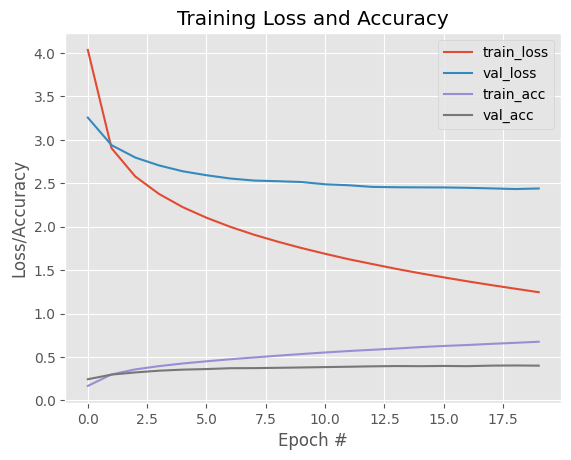

In [32]:
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import vgg19
from tensorflow.keras.applications import ResNet50
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from google.colab import drive

BASE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/DSC_Deep_Vision/modelos' # Ajustar el directorio raíz de Google Drive

# Carga de datos
print("[INFO]: Loading CIFAR-100 data...")
((x_train, y_train), (x_test, y_test)) = cifar100.load_data()

# CIFAR100 labelnames
labelNames = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# Pasamos las etiquetas a One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Normalizamos los datos
x_train = vgg19.preprocess_input(x_train)
x_test = vgg19.preprocess_input(x_test)

base_model = ResNet50(weights='imagenet',
                 include_top=False, # No incluir el Top Model (parte destinada a la clasificación)
                 input_shape=(32,32,3))
base_model.summary()

# conectarlo a nueva parte densa
base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(512, activation='relu'))
pre_trained_model.add(layers.Dense(100, activation='softmax'))

pre_trained_model.summary()

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
pre_trained_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_pre = pre_trained_model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.2)

# Montamos la unidad de Drive
# drive.mount('/content/drive')
# Almacenamos el modelo empleando la función mdoel.save de Keras
# pre_trained_model.save(BASE_FOLDER+"deepCNN_CIFAR100_pretrained.h5")

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")

# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = pre_trained_model.predict(x_test, batch_size=256)

# Sacamos el report para test
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H_pre.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H_pre.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H_pre.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H_pre.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

## **2. FINE TUNING**

#### **Descongelamos última capa convolucional (41% Accuracy)**

[INFO]: Loading CIFAR-100 data...
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_24[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                         

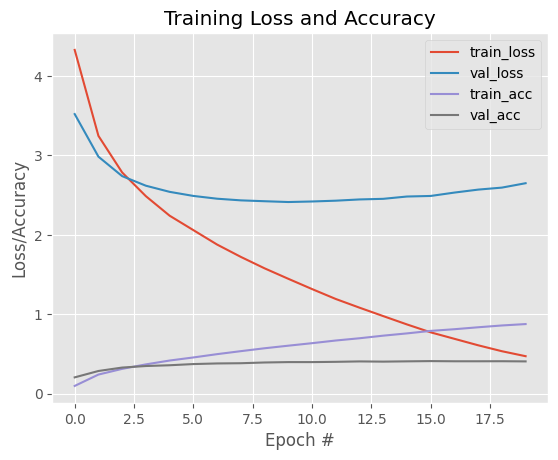

In [44]:
# Imports que vamos a necesitar
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import vgg19, VGG19
from tensorflow.keras.applications import ResNet50,resnet50
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

BASE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/DSC_Deep_Vision/modelos' # Ajustar el directorio raíz de Google Drive

# Carga de datos
print("[INFO]: Loading CIFAR-100 data...")
((x_train, y_train), (x_test, y_test)) = cifar100.load_data()

# CIFAR100 labelnames
input_shape = (32, 32, 3)
labelNames = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# Pasamos las etiquetas a One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Normalizamos los datos

x_train = resnet50.preprocess_input(x_train)
x_test = resnet50.preprocess_input(x_test)

# Importamos VGG19 con pesos de imagenet y sin Top Model especificando tamaño de entrada de datos
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Mostramos la arquitectura
base_model.summary()

# Congelamos las capas de los 4 primeros bloques convolucionales, el quinto se re-entrena
# Por defecto todas las capas estás a layer.trainable = True (entrenables)
# En base_model.layers.name tenemos la información del nombre de la capa
for layer in base_model.layers:
  if layer.name == 'conv5_block2_1_conv':
    break
  layer.trainable = False
  print('Capa ' + layer.name + ' congelada...')

# Añadimos nuestro clasificador (Top Model)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(1024, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', name='fc2')(x)
x = Dense(100, activation='softmax', name='predictions')(x)
model = Model(base_model.input, x)

# Compilamos el modelo
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Vamos a visualizar el modelo prestando especial atención en el número de pesos total y el número de pesos entrenables.
model.summary()

# Entrenamos el modelo
H = model.fit(x_train, y_train, validation_split=0.2, batch_size=256, epochs=20, verbose=1)

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")
predictions = model.predict(x_test, batch_size=64)

# Obtener el report de clasificación
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


#### **Descongelamos 2 últimas capas convolucionales (Accuracy 43%)**

[INFO]: Loading CIFAR-100 data...
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_25[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                         

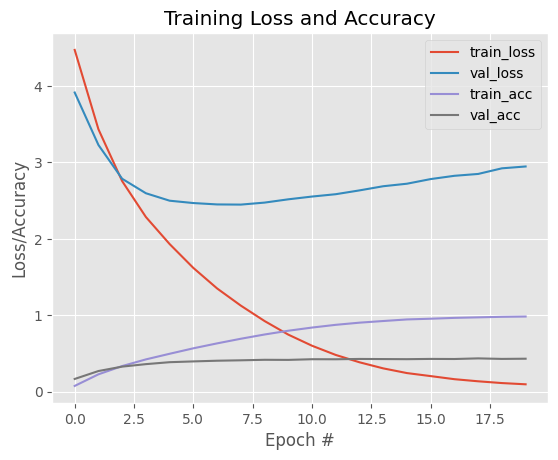

In [45]:
# Imports que vamos a necesitar
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import vgg19, VGG19
from tensorflow.keras.applications import ResNet50,resnet50
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

BASE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/DSC_Deep_Vision/modelos' # Ajustar el directorio raíz de Google Drive

# Carga de datos
print("[INFO]: Loading CIFAR-100 data...")
((x_train, y_train), (x_test, y_test)) = cifar100.load_data()

# CIFAR100 labelnames
input_shape = (32, 32, 3)
labelNames = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# Pasamos las etiquetas a One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Normalizamos los datos

x_train = resnet50.preprocess_input(x_train)
x_test = resnet50.preprocess_input(x_test)

# Importamos VGG19 con pesos de imagenet y sin Top Model especificando tamaño de entrada de datos
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Mostramos la arquitectura
base_model.summary()

# Congelamos las capas de los 4 primeros bloques convolucionales, el quinto se re-entrena
# Por defecto todas las capas estás a layer.trainable = True (entrenables)
# En base_model.layers.name tenemos la información del nombre de la capa
for layer in base_model.layers:
  if layer.name == 'conv4_block4_3_conv':
    break
  layer.trainable = False
  print('Capa ' + layer.name + ' congelada...')

# Añadimos nuestro clasificador (Top Model)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(1024, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', name='fc2')(x)
x = Dense(100, activation='softmax', name='predictions')(x)
model = Model(base_model.input, x)

# Compilamos el modelo
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Vamos a visualizar el modelo prestando especial atención en el número de pesos total y el número de pesos entrenables.
model.summary()

# Entrenamos el modelo
H = model.fit(x_train, y_train, validation_split=0.2, batch_size=256, epochs=20, verbose=1)

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")
predictions = model.predict(x_test, batch_size=64)

# Obtener el report de clasificación
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


### **Análisis de resultados**

Se condigue mejorar ligeramente el accuracy, del 40% al 43%



## **3. AJUSTE ESTRUCTURA TOP MODEL**

### **3.1. Primer intento (Accuracy 39 %)**

Se modifica la estructura del Top Model modificando la hidden layer a 256 neuronas.

[INFO]: Loading CIFAR-100 data...
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_28[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                         

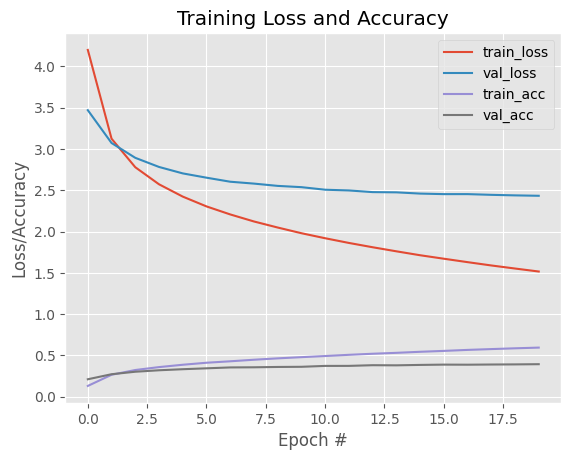

In [ ]:
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import vgg19
from tensorflow.keras.applications import ResNet50,resnet50
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from google.colab import drive

BASE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/DSC_Deep_Vision/modelos' # Ajustar el directorio raíz de Google Drive

# Carga de datos
print("[INFO]: Loading CIFAR-100 data...")
((x_train, y_train), (x_test, y_test)) = cifar100.load_data()

# CIFAR100 labelnames
labelNames = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# Pasamos las etiquetas a One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Normalizamos los datos
x_train = resnet50.preprocess_input(x_train)
x_test = resnet50.preprocess_input(x_test)

base_model = ResNet50(weights='imagenet',
                 include_top=False, # No incluir el Top Model (parte destinada a la clasificación)
                 input_shape=(32,32,3))
base_model.summary()

# conectarlo a nueva parte densa
base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(256, activation='relu'))
pre_trained_model.add(layers.Dense(100, activation='softmax'))

pre_trained_model.summary()

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
pre_trained_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_pre = pre_trained_model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.2)

# Montamos la unidad de Drive
# drive.mount('/content/drive')
# Almacenamos el modelo empleando la función mdoel.save de Keras
# pre_trained_model.save(BASE_FOLDER+"deepCNN_CIFAR100_pretrained.h5")

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")

# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = pre_trained_model.predict(x_test, batch_size=256)

# Sacamos el report para test
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H_pre.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H_pre.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H_pre.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H_pre.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### **3.2. Segundo intento (Accuracy 39 %)**

Se crean dos hidden layers de 1024 y 256 neuronas en el Top Model.

[INFO]: Loading CIFAR-100 data...
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_29[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                         

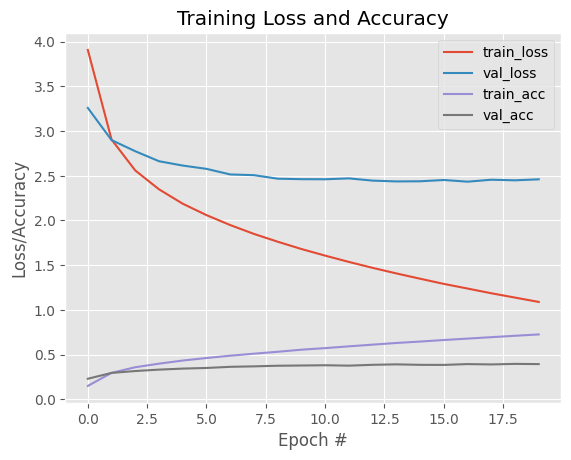

In [49]:
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import resnet50
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from google.colab import drive

BASE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/DSC_Deep_Vision/modelos' # Ajustar el directorio raíz de Google Drive

# Carga de datos
print("[INFO]: Loading CIFAR-100 data...")
((x_train, y_train), (x_test, y_test)) = cifar100.load_data()

# CIFAR100 labelnames
labelNames = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# Pasamos las etiquetas a One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Normalizamos los datos
x_train = resnet50.preprocess_input(x_train)
x_test = resnet50.preprocess_input(x_test)

base_model = ResNet50(weights='imagenet',
                 include_top=False, # No incluir el Top Model (parte destinada a la clasificación)
                 input_shape=(32,32,3))
base_model.summary()

# conectarlo a nueva parte densa
base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(1024, activation='relu'))
pre_trained_model.add(layers.Dense(256, activation='relu'))
pre_trained_model.add(layers.Dense(100, activation='softmax'))
pre_trained_model.summary()

pre_trained_model.summary()

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
pre_trained_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_pre = pre_trained_model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.2)

# Montamos la unidad de Drive
# drive.mount('/content/drive')
# Almacenamos el modelo empleando la función mdoel.save de Keras
# pre_trained_model.save(BASE_FOLDER+"deepCNN_CIFAR100_pretrained.h5")

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")

# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = pre_trained_model.predict(x_test, batch_size=256)

# Sacamos el report para test
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H_pre.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H_pre.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H_pre.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H_pre.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

## **4. AJUSTE PARÁMETROS DE REGULARIZACIÓN**

### **4.1. Weight regularization L2 (Accuracy 41%)**

No se mejora ni el accuracy ni el overfitting.

[INFO]: Loading CIFAR-100 data...
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_30[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                         

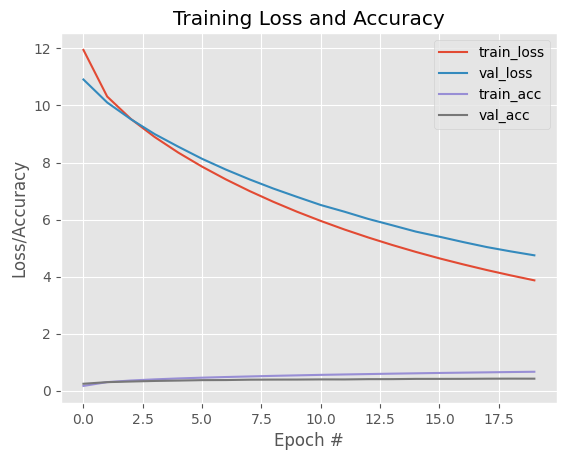

In [50]:
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import resnet50
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from google.colab import drive

BASE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/DSC_Deep_Vision/modelos' # Ajustar el directorio raíz de Google Drive

# Carga de datos
print("[INFO]: Loading CIFAR-100 data...")
((x_train, y_train), (x_test, y_test)) = cifar100.load_data()

# CIFAR100 labelnames
labelNames = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# Pasamos las etiquetas a One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Normalizamos los datos
x_train = resnet50.preprocess_input(x_train)
x_test = resnet50.preprocess_input(x_test)

base_model = ResNet50(weights='imagenet',
                 include_top=False, # No incluir el Top Model (parte destinada a la clasificación)
                 input_shape=(32,32,3))
base_model.summary()

# conectarlo a nueva parte densa
base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
pre_trained_model.add(layers.Dense(100, activation='softmax'))


pre_trained_model.summary()

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
pre_trained_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_pre = pre_trained_model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.2)

# Montamos la unidad de Drive
# drive.mount('/content/drive')
# Almacenamos el modelo empleando la función mdoel.save de Keras
# pre_trained_model.save(BASE_FOLDER+"deepCNN_CIFAR100_pretrained.h5")

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")

# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = pre_trained_model.predict(x_test, batch_size=256)

# Sacamos el report para test
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H_pre.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H_pre.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H_pre.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H_pre.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

Mejora muy ligeramente el overfitting

### **4.2. Dropout (Accuracy 36%)**

[INFO]: Loading CIFAR-100 data...
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_31[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                         

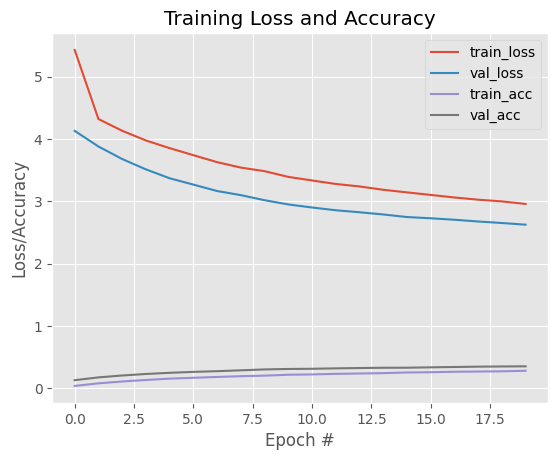

In [51]:
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import resnet50
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from google.colab import drive

BASE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/DSC_Deep_Vision/modelos' # Ajustar el directorio raíz de Google Drive

# Carga de datos
print("[INFO]: Loading CIFAR-100 data...")
((x_train, y_train), (x_test, y_test)) = cifar100.load_data()

# CIFAR100 labelnames
labelNames = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# Pasamos las etiquetas a One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Normalizamos los datos
x_train = resnet50.preprocess_input(x_train)
x_test = resnet50.preprocess_input(x_test)

base_model = ResNet50(weights='imagenet',
                 include_top=False, # No incluir el Top Model (parte destinada a la clasificación)
                 input_shape=(32,32,3))
base_model.summary()

# conectarlo a nueva parte densa
base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(512, activation='relu'))
pre_trained_model.add(Dropout(0.75))
pre_trained_model.add(layers.Dense(100, activation='softmax'))

pre_trained_model.summary()

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
pre_trained_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_pre = pre_trained_model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.2)

# Montamos la unidad de Drive
# drive.mount('/content/drive')
# Almacenamos el modelo empleando la función mdoel.save de Keras
# pre_trained_model.save(BASE_FOLDER+"deepCNN_CIFAR100_pretrained.h5")

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")

# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = pre_trained_model.predict(x_test, batch_size=256)

# Sacamos el report para test
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H_pre.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H_pre.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H_pre.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H_pre.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

No se mejora ni el accuracy ni el overfitting.

### **4.3. Batch normalization (Accuracy 41%)**

[INFO]: Loading CIFAR-100 data...
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_32[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                         

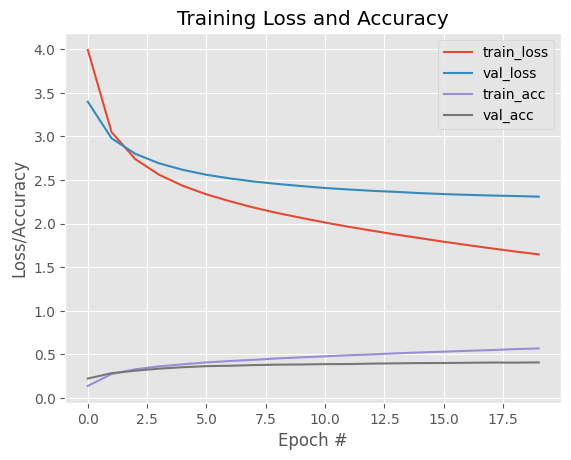

In [52]:
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import resnet50
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from google.colab import drive

BASE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/DSC_Deep_Vision/modelos' # Ajustar el directorio raíz de Google Drive

# Carga de datos
print("[INFO]: Loading CIFAR-100 data...")
((x_train, y_train), (x_test, y_test)) = cifar100.load_data()

# CIFAR100 labelnames
labelNames = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# Pasamos las etiquetas a One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Normalizamos los datos
x_train = resnet50.preprocess_input(x_train)
x_test = resnet50.preprocess_input(x_test)

base_model = ResNet50(weights='imagenet',
                 include_top=False, # No incluir el Top Model (parte destinada a la clasificación)
                 input_shape=(32,32,3))
base_model.summary()

# conectarlo a nueva parte densa
base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(512, activation='relu'))
pre_trained_model.add(BatchNormalization())
pre_trained_model.add(layers.Dense(100, activation='softmax'))

pre_trained_model.summary()

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
pre_trained_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_pre = pre_trained_model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.2)

# Montamos la unidad de Drive
# drive.mount('/content/drive')
# Almacenamos el modelo empleando la función mdoel.save de Keras
# pre_trained_model.save(BASE_FOLDER+"deepCNN_CIFAR100_pretrained.h5")

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")

# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = pre_trained_model.predict(x_test, batch_size=256)

# Sacamos el report para test
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H_pre.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H_pre.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H_pre.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H_pre.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### **4.4. Combinación de las 3 técnicas de regularización (Accuracy 40%)**

[INFO]: Loading CIFAR-100 data...
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_33[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                         

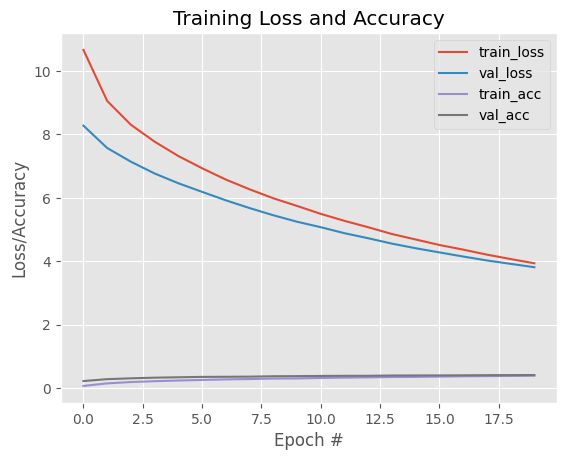

In [53]:
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import resnet50
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from google.colab import drive

BASE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/DSC_Deep_Vision/modelos' # Ajustar el directorio raíz de Google Drive

# Carga de datos
print("[INFO]: Loading CIFAR-100 data...")
((x_train, y_train), (x_test, y_test)) = cifar100.load_data()

# CIFAR100 labelnames
labelNames = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# Pasamos las etiquetas a One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Normalizamos los datos
x_train = resnet50.preprocess_input(x_train)
x_test = resnet50.preprocess_input(x_test)

base_model = ResNet50(weights='imagenet',
                 include_top=False, # No incluir el Top Model (parte destinada a la clasificación)
                 input_shape=(32,32,3))
base_model.summary()

# conectarlo a nueva parte densa
base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(512, activation='relu'))
pre_trained_model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
pre_trained_model.add(BatchNormalization())
pre_trained_model.add(Dropout(0.75))
pre_trained_model.add(layers.Dense(100, activation='softmax'))

pre_trained_model.summary()

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
pre_trained_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_pre = pre_trained_model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.2)

# Montamos la unidad de Drive
# drive.mount('/content/drive')
# Almacenamos el modelo empleando la función mdoel.save de Keras
# pre_trained_model.save(BASE_FOLDER+"deepCNN_CIFAR100_pretrained.h5")

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")

# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = pre_trained_model.predict(x_test, batch_size=256)

# Sacamos el report para test
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H_pre.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H_pre.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H_pre.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H_pre.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# **Conclusiones Estrategia 1**

Con la **red preentrenada** ResNet50 se consigue un accuracy superior, 40%, que con la red VGG19, 35%. Vemos que no es un amuy buena preción pero aplicando otras técnicas hemos mejorado ligeramente el modelo.

Se ha mejorado el modelo aplicando **fine tuning** con la red VGG19, de un 35 % a un 48%. EN cambio con la res ResNet50 no se ha mejorado el modelo.

Se ha intentado mejorar el rendiento del modelo modificando la **arquitectura del Top Model**. Sin embargo, ni aumentando significativamente el número de neuronas se ha conseguido mejorar la precisión. Aunque hay que recordar que ya se partía de una precisión bastante alta.

Posteriormente, se ha intentado mejorar el rendimiento ajustando **parámetros de regularización**. No se han conseguido grandes mejoras al tener el base model totalmente congelado. Únicamente haciendo uso de batch normalization se ha conseguido mejorar ligeramente la precisión y el overfitting.

Se ha conseguido mejorar ligeramente el modelos utlizando **Data Augmentation**. Únicamnete se ha realizado en el caso de la red pre-entrenada VGG19. Hay que tener en cuenta que el base model está congelado y solo interfiere en el top model. Este aumento de muestras no interviene en la fase de extracción de características de las imágenes, lo que explica que no se consiga una mejora en el overfitting.

# Importaciones y carga de datos

> Bloque con sangría



In [ ]:
from tensorflow.keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from re import X
from tensorflow import keras


# Pre-procesado obligatorio cuando trabajo con redes neuronales
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.backend import expand_dims

# Construccion de una red CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.metrics import classification_report
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report
from tensorflow.keras.applications import VGG16 #red que queramos usar, ejemplo vgg16, vgg19, ResNet50, Xception, InceptionV3, InceptionResNetV2, DenseNet, RasNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
from tensorflow.keras import regularizers


#Visualización de imagen
from tensorflow.keras.preprocessing.image import array_to_img
import time

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3047545454446069249
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14328594432
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5212120989263911504
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


# ESTRATEGIA 2 : Crear una red desde cero

##Importación de cifar100 y Acondicionamiento del conjunto de datos


In [ ]:
def shapes(*x):
    for idx, item in enumerate(x):
        print(f"arg_{idx}: {item.shape}") if hasattr(item, "shape") else print(f"arg_{idx}: {len(item)}")

In [ ]:
from keras.datasets import cifar100
from IPython.display import clear_output

(x_train, y_train_r), (x_test, y_test_r) = cifar100.load_data(label_mode='fine')
x_train, x_test = x_train/255, x_test/255
y_train, y_test = keras.utils.to_categorical(y_train_r, 100), keras.utils.to_categorical(y_test_r, 100)
clear_output()
# Mostrar la forma de los conjuntos de datos
print("Forma de los conjuntos de datos:")
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)
print("y_train_r:", y_train_r.shape)
print("y_test_r:", y_test_r.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Forma de los conjuntos de datos:
x_train: (50000, 32, 32, 3)
x_test: (10000, 32, 32, 3)
y_train_r: (50000, 1)
y_test_r: (10000, 1)
y_train: (50000, 100)
y_test: (10000, 100)


In [ ]:
# CIFAR100 labelnames
labelNames = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']


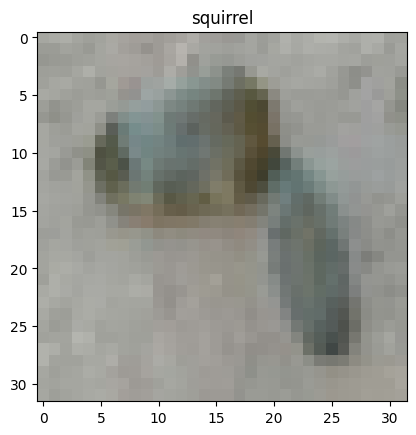

In [ ]:
for i in np.random.permutation(len(x_train)-1)[:10]:
    plt.imshow(x_train[i])
    plt.title(labelNames[int(y_train_r[i])])
    plt.show()
    time.sleep(0.5)
    clear_output(wait=True)

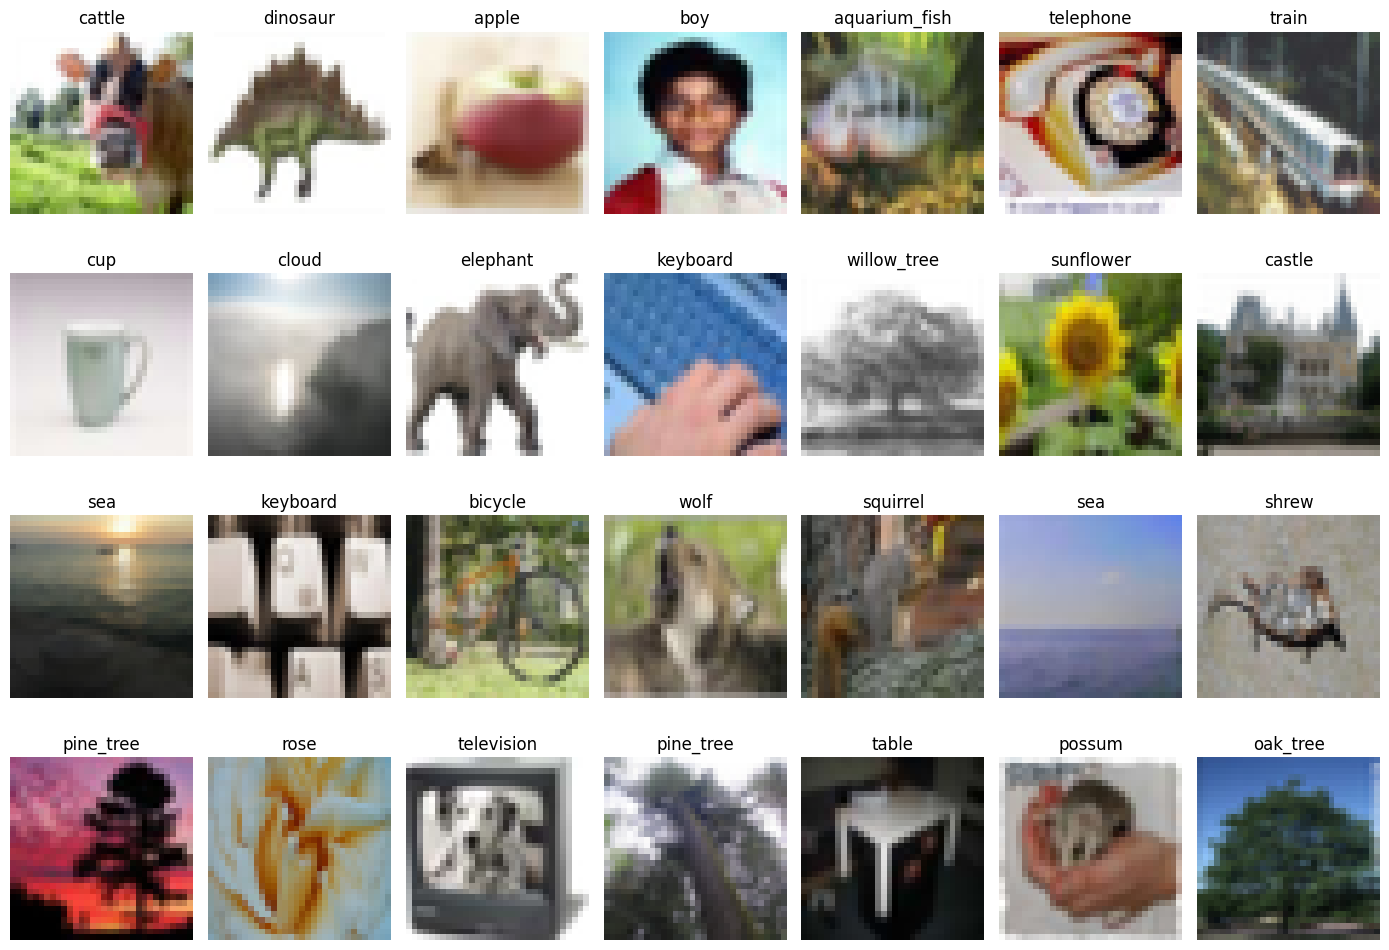

In [ ]:
# Crear una figura y ejes de subtrama
fig, axes = plt.subplots(4, 7, figsize=(14, 10))
axes = axes.flatten()

# Mostrar las imágenes con etiquetas
for i in range(len(axes)):
    axes[i].imshow(x_train[i])
    axes[i].set_title(labelNames[y_train_r[i][0]])
    axes[i].axis('off')

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()


#Diferentes Redes

## 1er modelo: SLP (Single Layer Perceptron) (Epoch 20 loss: 3.0545 - accuracy: 0.2596 - val_loss: 3.4027 - val_accuracy: 0.2109)

Epoch 1/20
391/391 [==============================] - 4s 5ms/step - loss: 135.6497 - accuracy: 0.0537 - val_loss: 113.5477 - val_accuracy: 0.0501
Epoch 2/20
391/391 [==============================] - 2s 4ms/step - loss: 83.7502 - accuracy: 0.0699 - val_loss: 88.6551 - val_accuracy: 0.0534
Epoch 3/20
391/391 [==============================] - 2s 4ms/step - loss: 59.5535 - accuracy: 0.0844 - val_loss: 62.5669 - val_accuracy: 0.0571
Epoch 4/20
391/391 [==============================] - 2s 5ms/step - loss: 42.4358 - accuracy: 0.0959 - val_loss: 45.6896 - val_accuracy: 0.0698
Epoch 5/20
391/391 [==============================] - 2s 6ms/step - loss: 32.8607 - accuracy: 0.1100 - val_loss: 41.4826 - val_accuracy: 0.0699
Epoch 6/20
391/391 [==============================] - 2s 5ms/step - loss: 25.1749 - accuracy: 0.1195 - val_loss: 30.3590 - val_accuracy: 0.0753
Epoch 7/20
391/391 [==============================] - 2s 4ms/step - loss: 19.5016 - accuracy: 0.1311 - val_loss: 24.0585 - val_accurac

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


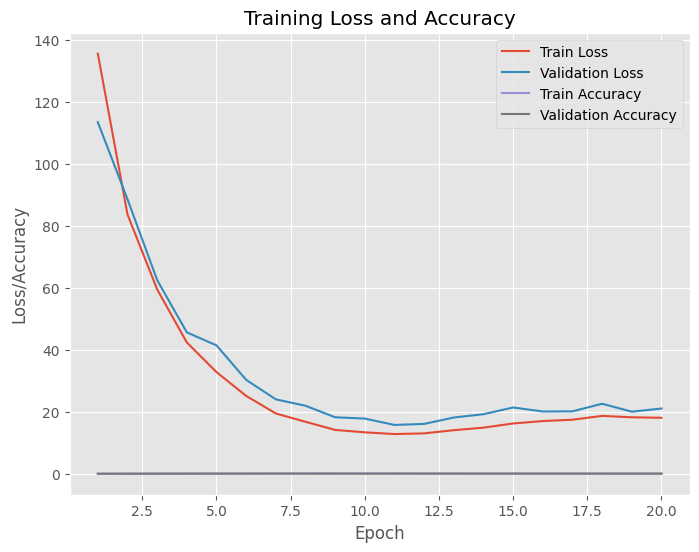

In [55]:
slp_model = keras.Sequential(
    [keras.layers.Flatten(input_shape = (32,32,3)),
     keras.layers.Dense(512, activation=tf.nn.relu),
     keras.layers.Dense(100, activation=tf.nn.softmax)])

slp_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

H1 = slp_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size = 128)

print("[INFO]: Evaluando modelo...")
predictionsslp = slp_model.predict(x_test, batch_size=32)

# Obtenemos el reporte de clasificación
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictionsslp, axis=1), target_names=labelNames))

# Mostrar gráfica de loss y accuracy
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
epochs = range(1, len(H1.history['loss']) + 1)

plt.plot(epochs, H1.history["loss"], label="Train Loss")
plt.plot(epochs, H1.history["val_loss"], label="Validation Loss")
plt.plot(epochs, H1.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, H1.history["val_accuracy"], label="Validation Accuracy")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

## 2º Modelo: MLP (Multi Layer Perceptron) (Epoch 50, loss: 2.6315 - accuracy: 0.3275 - val_loss: 4.0289 - val_accuracy: 0.2076)

Epoch 1/50
1563/1563 [==============================] - 7s 4ms/step - loss: 4.0531 - accuracy: 0.0805 - val_loss: 3.8336 - val_accuracy: 0.1163
Epoch 2/50
1563/1563 [==============================] - 6s 4ms/step - loss: 3.6708 - accuracy: 0.1389 - val_loss: 3.5911 - val_accuracy: 0.1544
Epoch 3/50
1563/1563 [==============================] - 5s 3ms/step - loss: 3.5105 - accuracy: 0.1662 - val_loss: 3.5106 - val_accuracy: 0.1725
Epoch 4/50
1563/1563 [==============================] - 5s 3ms/step - loss: 3.4030 - accuracy: 0.1866 - val_loss: 3.4632 - val_accuracy: 0.1861
Epoch 5/50
1563/1563 [==============================] - 5s 3ms/step - loss: 3.3286 - accuracy: 0.1985 - val_loss: 3.4259 - val_accuracy: 0.1950
Epoch 6/50
1563/1563 [==============================] - 5s 3ms/step - loss: 3.2679 - accuracy: 0.2081 - val_loss: 3.3876 - val_accuracy: 0.2029
Epoch 7/50
1563/1563 [==============================] - 5s 3ms/step - loss: 3.2127 - accuracy: 0.2181 - val_loss: 3.3692 - val_accuracy:

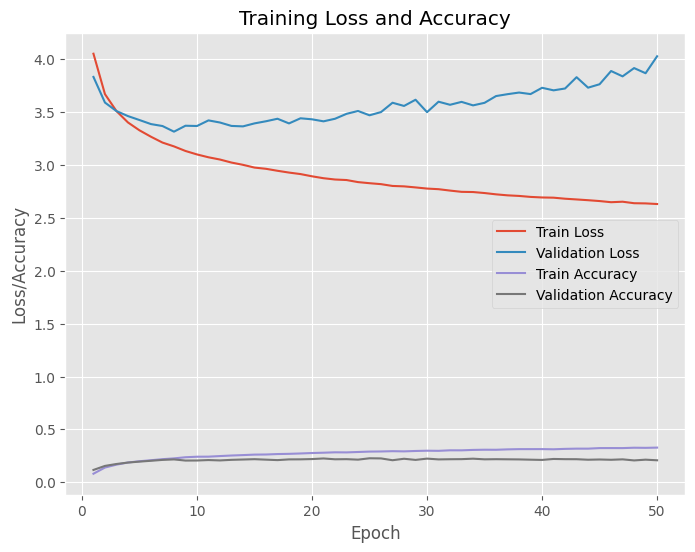

In [ ]:
mlp_model = keras.Sequential(
    [keras.layers.Flatten(input_shape = (32,32,3)),
     keras.layers.Dense(512, activation=tf.nn.relu),
     keras.layers.Dense(256, activation=tf.nn.relu),
     keras.layers.Dense(100, activation=tf.nn.softmax)]
)

mlp_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

H2 = mlp_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50)


print("[INFO]: Evaluando modelo...")
predictionsmlp = mlp_model.predict(x_test, batch_size=32)

# Obtenemos el reporte de clasificación
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictionsmlp, axis=1), target_names=labelNames))

# Mostrar gráfica de loss y accuracy
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
epochs = range(1, len(H2.history['loss']) + 1)

plt.plot(epochs, H2.history["loss"], label="Train Loss")
plt.plot(epochs, H2.history["val_loss"], label="Validation Loss")
plt.plot(epochs, H2.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, H2.history["val_accuracy"], label="Validation Accuracy")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


## 3º Modelo: CNN (Convolution Network)  (Test Loss: 1.745, Test Accuracy: 0.544, Trainable params: 1,2M) epoch 300

Se hizo una prueba inicial con las capas más sencillas.
Al inicio se tuvieron 30 pruebas pero al ver que el modelo seguía aprendiendo se fueron subiendo gradualmente hasta hacer una prueba de 300 epochs.
Aunque se ve que no hay overfitting hasta el epoch aproximado 150, el modelo deja de aprender y se estanca en ese nivel de accuracy tanto para train como validation.

Parámetros clave: BatchNormalization,
MaxPooling2D (2)

Activación: Relu. Datos de aumento: 64, 128, 256, 512)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        18464     
                                                                 
 batch_normalization_1 (Batc  (None, 11, 11, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 5, 32)         0     

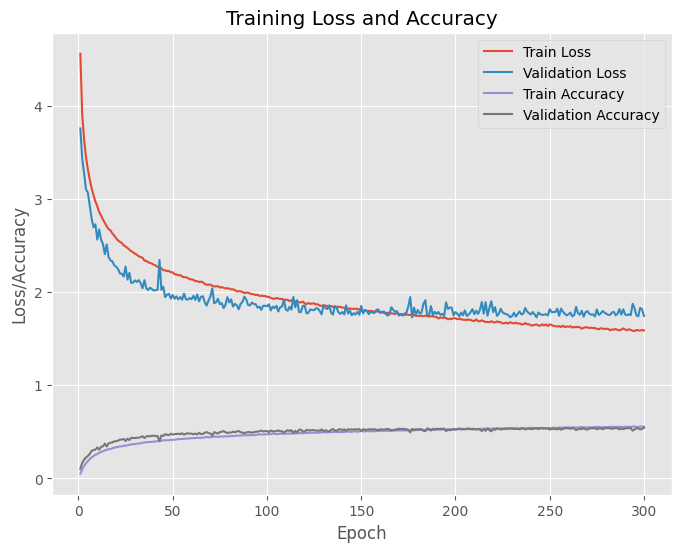

In [ ]:
# Definir el modelo
inputs = keras.Input(shape=(32, 32, 3))
x1 = Conv2D(64, 3, 1, padding="same", activation="relu")(inputs)
x1 = BatchNormalization()(x1)
x1 = Conv2D(32, 3, 3, padding="same", activation="relu")(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(2)(x1)  # se incorpora para reducir la dimensionalidad en cada una de las capas
x1 = Dropout(0.5)(x1)

x2 = Conv2D(128, 3, 1, padding="same", activation="relu")(x1)
x2 = BatchNormalization()(x2)
x2 = Conv2D(128, 3, 1, padding="same", activation="relu")(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Dropout(0.5)(x2)

x3 = Conv2D(256, 3, 1, padding="same", activation="relu")(x2)
x3 = BatchNormalization()(x3)
x3 = Conv2D(256, 3, 1, padding="same", activation="relu")(x3)
x3 = BatchNormalization()(x3)
x3 = MaxPooling2D(2)(x3)
x3 = Dropout(0.5)(x3)

xfc = Flatten()(x3)
xfc = Dense(512, activation="relu")(xfc)
xfc = BatchNormalization()(xfc)
xfc = Dropout(0.5)(xfc)

outputs = Dense(100, activation="softmax")(xfc)

conv_model = keras.Model(inputs=inputs, outputs=outputs)

conv_model.summary()

# Compilar el modelo
conv_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Entrenar el modelo
H3 = conv_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=300)

# Evaluar el modelo
loss, accuracy = conv_model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

print("[INFO]: Evaluando modelo...")
predictionsconv = conv_model.predict(x_test, batch_size=32)

# Obtenemos el reporte de clasificación
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictionsconv, axis=1), target_names=labelNames))

# Mostrar gráfica de loss y accuracy
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
epochs = range(1, len(H3.history['loss']) + 1)

plt.plot(epochs, H3.history["loss"], label="Train Loss")
plt.plot(epochs, H3.history["val_loss"], label="Validation Loss")
plt.plot(epochs, H3.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, H3.history["val_accuracy"], label="Validation Accuracy")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

 ## 4º Modelo CNN (Test Loss: 2.23,Test Accuracy: 0.555, Trainable params: 4,2M) Se mete un Regularizador al 0.0001

  Se incrementó al 3 los parámetros entrenables con mayores controles. Implementación del kernel_regularizer: para aplicar penalizaciones en cada capa que es sumada a la perdida para mejorar la optimización y controlar la complejidad del modelo.

 Empieza a aprender más lento pero luego acelera su aprendizaje.
 Tenemos un test loss más alto, y sólo mejora un .01 con respecto al anterior.

 No siempre una red más compleja trae mejores resultados. Y aunque el accuracy es casi igual, en algunas categorías se encuentran valores al .88, y muchas más categorías arriba del .70

 Otro punto a favor es que no se ve un overfitting durante el entrenamiento.




Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_16 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_17 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 64)       0   

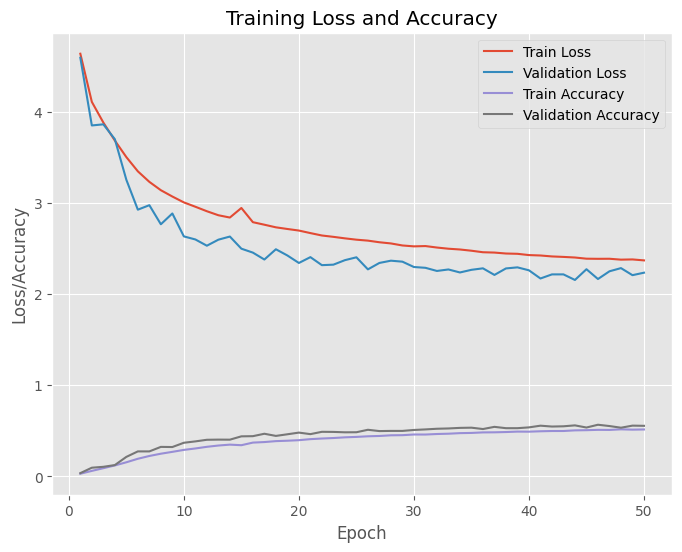

In [ ]:
# Definir el modelo


inputs = keras.Input(shape=(32, 32, 3))
x1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu",
            kernel_regularizer=regularizers.L2(1e-4))(inputs)
x1 = BatchNormalization()(x1)
x1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Dropout(0.5)(x1)


x2 = Conv2D(filters =128, kernel_size=(3, 3), padding="same", activation="relu",
            kernel_regularizer=regularizers.L2(1e-4))(x1)
x2 = BatchNormalization()(x2)
x2 = Conv2D(filters =128, kernel_size=(3, 3), padding="same", activation="relu")(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Dropout(0.5)(x2)

x3 = Conv2D(filters = 256, kernel_size = (3, 3), padding="same", activation="relu",
            kernel_regularizer=regularizers.L2(1e-4))(x2)
x3 = BatchNormalization()(x3)
x3 = Conv2D(256, 3, 1, padding="same", activation="relu")(x3)
x3 = BatchNormalization()(x3)
x3 = MaxPooling2D(2)(x3)
x3 = Dropout(0.5)(x3)

x4 = Conv2D(filters = 512, kernel_size = (3, 3), padding="same", activation="relu",
            kernel_regularizer=regularizers.L2(1e-4))(x3)
x4 = BatchNormalization()(x4)
x4 = Conv2D(256, 3, 1, padding="same", activation="relu")(x4)
x4 = BatchNormalization()(x4)
x4 = MaxPooling2D(2)(x4)
x4 = Dropout(0.5)(x4)

xfc = Flatten()(x4)
xfc = Dense(512, activation="relu")(xfc)
xfc = (Dropout(0.5))(xfc)
xfc = Dense (256, activation="relu")(xfc)
xfc = (Dropout(0.5))(xfc)
xfc = Dense (128, activation="relu")(xfc)
xfc = BatchNormalization()(xfc)
xfc = Dropout(0.5)(xfc)

outputs = Dense(100, activation="softmax")(xfc)

conv_model = keras.Model(inputs=inputs, outputs=outputs)

conv_model.summary()

# Compilar el modelo
conv_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Entrenar el modelo
H3 = conv_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50)

# Evaluar el modelo
loss, accuracy = conv_model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

print("[INFO]: Evaluando modelo...")
predictionsconv = conv_model.predict(x_test, batch_size=32)

# Obtenemos el reporte de clasificación
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictionsconv, axis=1), target_names=labelNames))

# Mostrar gráfica de loss y accuracy
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
epochs = range(1, len(H3.history['loss']) + 1)

plt.plot(epochs, H3.history["loss"], label="Train Loss")
plt.plot(epochs, H3.history["val_loss"], label="Validation Loss")
plt.plot(epochs, H3.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, H3.history["val_accuracy"], label="Validation Accuracy")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

## 5º Modelo_CNN (Test Loss: 1.822, Test Accuracy: 0.5547, Trainable params: 1,4M)

Invertimos los filtros de mayor a menor, para tener una mayor discriminación al inicio del entrenamiento y una menor discriminación al final. De igual manera se redujo el Dropout del .5 al .25, lo que vemos a lo largo de los epochs que puede estar contribuyendo a un ligero overfitting que no habíamos visto en los modelos pasados.

Con esto aunque no mejoramos en el Accuracy, si mejoramos mucho en el Loss y los parámetros entrenables fueron menores, aún cuando el tiempo fuer mucho mayor, casi al doble.


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_38 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_43 (Bat  (None, 32, 32, 256)      1024      
 chNormalization)                                                
                                                                 
 conv2d_39 (Conv2D)          (None, 32, 32, 256)       590080    
                                                                 
 batch_normalization_44 (Bat  (None, 32, 32, 256)      1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 16, 16, 256)      0   

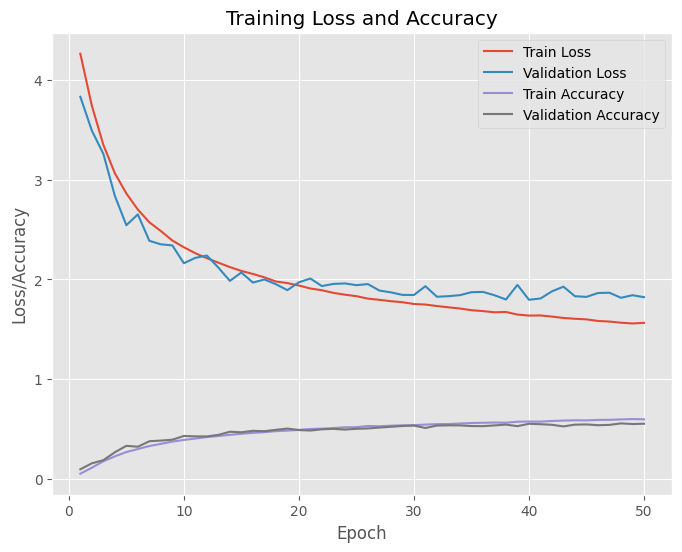

In [ ]:
# Definir el modelo
from tensorflow.keras import regularizers

inputs = keras.Input(shape=(32, 32, 3))
x1 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu",
            kernel_regularizer=regularizers.L2(1e-4))(inputs)
x1 = BatchNormalization()(x1)
x1 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Dropout(0.25)(x1)


x2 = Conv2D(filters =128, kernel_size=(3, 3), padding="same", activation="relu",
            kernel_regularizer=regularizers.L2(1e-4))(x1)
x2 = BatchNormalization()(x2)
x2 = Conv2D(filters =128, kernel_size=(3, 3), padding="same", activation="relu")(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Dropout(0.25)(x2)

x3 = Conv2D(filters = 64, kernel_size = (3, 3), padding="same", activation="relu")(x2)
x3 = BatchNormalization()(x3)
x3 = Conv2D(64, 3, 1, padding="same", activation="relu")(x3)
x3 = BatchNormalization()(x3)
x3 = MaxPooling2D(2)(x3)
x3 = Dropout(0.25)(x3)

x4 = Conv2D(filters = 32, kernel_size = (3, 3), padding="same", activation="relu")(x3)
x4 = BatchNormalization()(x4)
x4 = Conv2D(32, 3, 1, padding="same", activation="relu")(x4)
x4 = BatchNormalization()(x4)
x4 = MaxPooling2D(2)(x4)
x4 = Dropout(0.25)(x4)

xfc = Flatten()(x4)
xfc = Dense(512, activation="relu")(xfc)
xfc = (Dropout(0.25))(xfc)
xfc = Dense (256, activation="relu")(xfc)
xfc = (Dropout(0.25))(xfc)
xfc = Dense (128, activation="relu")(xfc)
xfc = BatchNormalization()(xfc)
xfc = Dropout(0.25)(xfc)

outputs = Dense(100, activation="softmax")(xfc)

conv_model = keras.Model(inputs=inputs, outputs=outputs)

conv_model.summary()

# Compilar el modelo
conv_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Entrenar el modelo
H3 = conv_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50)

# Evaluar el modelo
loss, accuracy = conv_model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

print("[INFO]: Evaluando modelo...")
predictionsconv = conv_model.predict(x_test, batch_size=32)

# Obtenemos el reporte de clasificación
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictionsconv, axis=1), target_names=labelNames))

# Mostrar gráfica de loss y accuracy
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
epochs = range(1, len(H3.history['loss']) + 1)

plt.plot(epochs, H3.history["loss"], label="Train Loss")
plt.plot(epochs, H3.history["val_loss"], label="Validation Loss")
plt.plot(epochs, H3.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, H3.history["val_accuracy"], label="Validation Accuracy")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

## 6º Modelo CNN (Test Loss: 1.63, Test Accuracy: 0.592, Total param:Trainable params: 4,2M ) Activation Swish

En este modelo se quitaron algunas capas, a la vez que se redujeron al inicio algunos filtros, y se mantuvo al inicio un dropout de 0.25.
Se prueba una nueva activación "swish", que ha ganado popularidad últimamente. Los regularizadores a niveles bajos al igual que los maxpooling y las batch normalization.

De igual manera se quitaron algunas capas en la última capa flatten, aumentando el Dropout.
Como concusión es que al tener muchos parámetros entrenables el tiempo es largo, y a partir del Epoch 15 se empieza a generar un overfitting.

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_47 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_53 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_48 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 batch_normalization_54 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 16, 16, 128)      0   

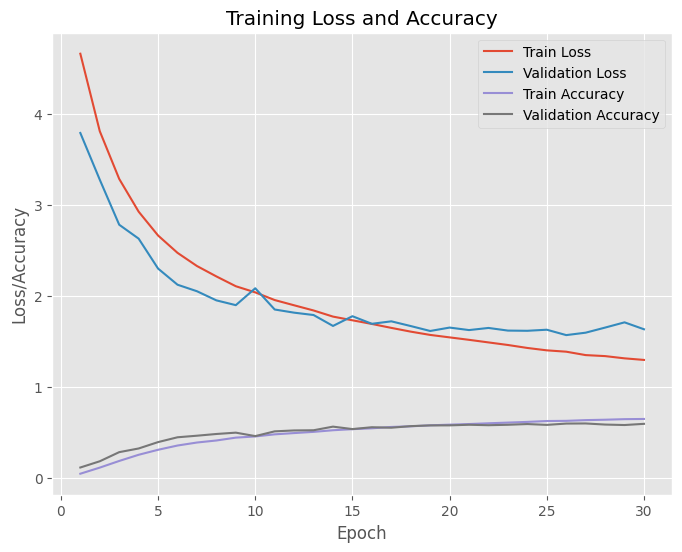

In [ ]:
# Definir el modelo
from tensorflow.keras import regularizers

inputs = keras.Input(shape=(32, 32, 3))
x1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="swish",
            kernel_regularizer=regularizers.L2(1e-4))(inputs)
x1 = BatchNormalization()(x1)
x1 = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="swish")(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Dropout(0.25)(x1)


x2 = Conv2D(filters =128, kernel_size=(3, 3), padding="same", activation="swish",
            kernel_regularizer=regularizers.L2(1e-4))(x1)
x2 = BatchNormalization()(x2)
x2 = Conv2D(filters =256, kernel_size=(3, 3), padding="same", activation="swish")(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Dropout(0.25)(x2)

x3 = Conv2D(filters = 256, kernel_size = (3, 3), padding="same", activation="swish")(x2)
x3 = BatchNormalization()(x3)
x3 = Conv2D(512, kernel_size=(3, 1), padding="same", activation="swish")(x3)
x3 = BatchNormalization()(x3)
x3 = MaxPooling2D(2)(x3)
x3 = Dropout(0.5)(x3)

x4 = Conv2D(filters = 512, kernel_size = (3, 3), padding="same", activation="swish")(x3)
x4 = BatchNormalization()(x4)
x4 = MaxPooling2D(2)(x4)
x4 = Dropout(0.25)(x4)

xfc = Flatten()(x4)
xfc = Dense(128, activation="swish")(xfc)
xfc = (Dropout(0.5))(xfc)
xfc = Dense (512, activation="swish")(xfc)
xfc = BatchNormalization()(xfc)
xfc = Dropout(0.5)(xfc)

outputs = Dense(100, activation="softmax")(xfc)

conv_model = keras.Model(inputs=inputs, outputs=outputs)

conv_model.summary()

# Compilar el modelo
conv_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Entrenar el modelo
H3 = conv_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30)

# Evaluar el modelo
loss, accuracy = conv_model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

print("[INFO]: Evaluando modelo...")
predictionsconv = conv_model.predict(x_test, batch_size=32)

# Obtenemos el reporte de clasificación
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictionsconv, axis=1), target_names=labelNames))

# Mostrar gráfica de loss y accuracy
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
epochs = range(1, len(H3.history['loss']) + 1)

plt.plot(epochs, H3.history["loss"], label="Train Loss")
plt.plot(epochs, H3.history["val_loss"], label="Validation Loss")
plt.plot(epochs, H3.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, H3.history["val_accuracy"], label="Validation Accuracy")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

## 7º Modelo CNN (Test Loss: 1.858, Test Accuracy: 0.531, Trainable params: 1,4 M) Activation: Swish

Se utilizó también la activation Swish con el modelo 5 que había tenido un buen accuracy y pérdida. Pero tardó mucho más tiempo y no mejoró en el accuracy comparado con el mismo modelo con la activación relu.


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_54 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_61 (Bat  (None, 32, 32, 256)      1024      
 chNormalization)                                                
                                                                 
 conv2d_55 (Conv2D)          (None, 32, 32, 256)       590080    
                                                                 
 batch_normalization_62 (Bat  (None, 32, 32, 256)      1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 16, 16, 256)      0   

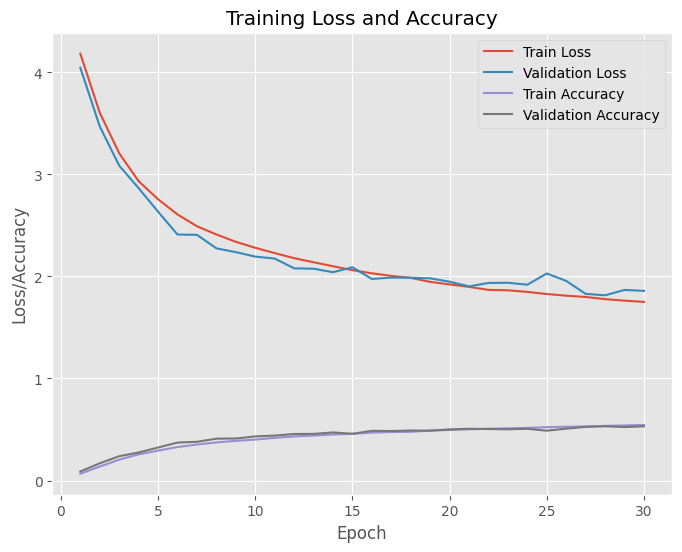

In [ ]:
# Definir el modelo
from tensorflow.keras import regularizers

inputs = keras.Input(shape=(32, 32, 3))
x1 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="swish",
            kernel_regularizer=regularizers.L2(1e-4))(inputs)
x1 = BatchNormalization()(x1)
x1 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="swish")(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Dropout(0.25)(x1)


x2 = Conv2D(filters =128, kernel_size=(3, 3), padding="same", activation="swish",
            kernel_regularizer=regularizers.L2(1e-4))(x1)
x2 = BatchNormalization()(x2)
x2 = Conv2D(filters =128, kernel_size=(3, 3), padding="same", activation="swish")(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Dropout(0.25)(x2)

x3 = Conv2D(filters = 64, kernel_size = (3, 3), padding="same", activation="swish")(x2)
x3 = BatchNormalization()(x3)
x3 = Conv2D(64, 3, 1, padding="same", activation="swish")(x3)
x3 = BatchNormalization()(x3)
x3 = MaxPooling2D(2)(x3)
x3 = Dropout(0.25)(x3)

x4 = Conv2D(filters = 32, kernel_size = (3, 3), padding="same", activation="swish")(x3)
x4 = BatchNormalization()(x4)
x4 = Conv2D(32, 3, 1, padding="same", activation="swish")(x4)
x4 = BatchNormalization()(x4)
x4 = MaxPooling2D(2)(x4)
x4 = Dropout(0.25)(x4)

xfc = Flatten()(x4)
xfc = Dense(512, activation="swish")(xfc)
xfc = (Dropout(0.25))(xfc)
xfc = Dense (256, activation="swish")(xfc)
xfc = (Dropout(0.25))(xfc)
xfc = Dense (128, activation="swish")(xfc)
xfc = BatchNormalization()(xfc)
xfc = Dropout(0.25)(xfc)

outputs = Dense(100, activation="softmax")(xfc)

conv_model = keras.Model(inputs=inputs, outputs=outputs)

conv_model.summary()

# Compilar el modelo
conv_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Entrenar el modelo
H3 = conv_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30)

# Evaluar el modelo
loss, accuracy = conv_model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

print("[INFO]: Evaluando modelo...")
predictionsconv = conv_model.predict(x_test, batch_size=32)

# Obtenemos el reporte de clasificación
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictionsconv, axis=1), target_names=labelNames))

# Mostrar gráfica de loss y accuracy
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
epochs = range(1, len(H3.history['loss']) + 1)

plt.plot(epochs, H3.history["loss"], label="Train Loss")
plt.plot(epochs, H3.history["val_loss"], label="Validation Loss")
plt.plot(epochs, H3.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, H3.history["val_accuracy"], label="Validation Accuracy")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

##Modelo 7 Seleccionado

### Modelo seleccionado: 7. Ajuste learning rate = 0.001 (Test Loss: 1.901, Test Accuracy: 0.519, Trainable params: 1,4M)

Se ha seleccionado el modelo 7 al tener un menor overfitting aunque tenga un loss ligeramente mayor y un accuracy ligeramente menor.

Se aplica un ajuste learning rate para mejorar el accuracy. Directamente se aplicó uno de los learning rate bajos que controlan en teoría mejor el overfitting y mejoran el loss.

Como resultado obtenemos que: Se enlentece el proceso y se sigue teniendo un ligero overfitting y el loss y el accuracy son ligeramente mayores y menores, respectivamente, que sin la aplicación del learning rate.



Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_98 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_111 (Ba  (None, 32, 32, 256)      1024      
 tchNormalization)                                               
                                                                 
 conv2d_99 (Conv2D)          (None, 32, 32, 256)       590080    
                                                                 
 batch_normalization_112 (Ba  (None, 32, 32, 256)      1024      
 tchNormalization)                                               
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 16, 16, 256)      0  

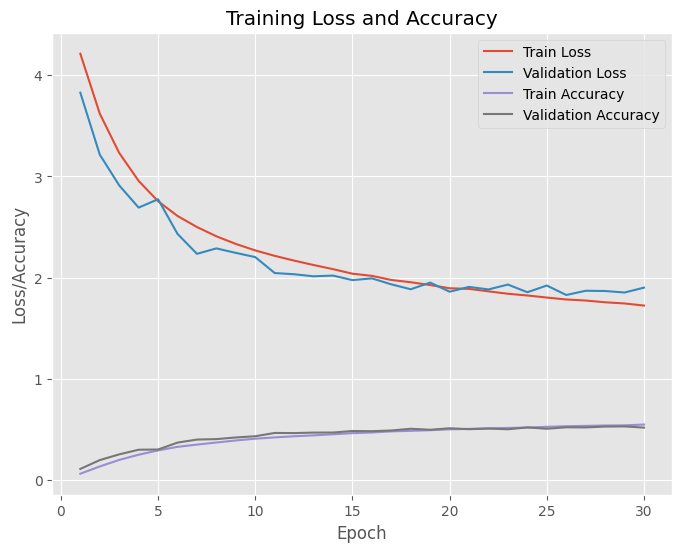

In [ ]:
# Definir el modelo
from tensorflow.keras import regularizers

inputs = keras.Input(shape=(32, 32, 3))
x1 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="swish",
            kernel_regularizer=regularizers.L2(1e-4))(inputs)
x1 = BatchNormalization()(x1)
x1 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="swish")(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Dropout(0.25)(x1)


x2 = Conv2D(filters =128, kernel_size=(3, 3), padding="same", activation="swish",
            kernel_regularizer=regularizers.L2(1e-4))(x1)
x2 = BatchNormalization()(x2)
x2 = Conv2D(filters =128, kernel_size=(3, 3), padding="same", activation="swish")(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Dropout(0.25)(x2)

x3 = Conv2D(filters = 64, kernel_size = (3, 3), padding="same", activation="swish")(x2)
x3 = BatchNormalization()(x3)
x3 = Conv2D(64, 3, 1, padding="same", activation="swish")(x3)
x3 = BatchNormalization()(x3)
x3 = MaxPooling2D(2)(x3)
x3 = Dropout(0.25)(x3)

x4 = Conv2D(filters = 32, kernel_size = (3, 3), padding="same", activation="swish")(x3)
x4 = BatchNormalization()(x4)
x4 = Conv2D(32, 3, 1, padding="same", activation="swish")(x4)
x4 = BatchNormalization()(x4)
x4 = MaxPooling2D(2)(x4)
x4 = Dropout(0.25)(x4)

xfc = Flatten()(x4)
xfc = Dense(512, activation="swish")(xfc)
xfc = (Dropout(0.25))(xfc)
xfc = Dense (256, activation="swish")(xfc)
xfc = (Dropout(0.25))(xfc)
xfc = Dense (128, activation="swish")(xfc)
xfc = BatchNormalization()(xfc)
xfc = Dropout(0.25)(xfc)

outputs = Dense(100, activation="softmax")(xfc)

conv_model = keras.Model(inputs=inputs, outputs=outputs)

conv_model.summary()

opt = Adam(learning_rate=0.001)

# Compila el modelo con el optimizador definido
conv_model.compile(optimizer=opt,
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Entrenar el modelo
H3 = conv_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30)

# Evaluar el modelo

# Entrenando la solución

loss, accuracy = conv_model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

print("[INFO]: Evaluando modelo...")
predictionsconv = conv_model.predict(x_test, batch_size=32)

# Obtenemos el reporte de clasificación
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictionsconv, axis=1), target_names=labelNames))

# Mostrar gráfica de loss y accuracy
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
epochs = range(1, len(H3.history['loss']) + 1)

plt.plot(epochs, H3.history["loss"], label="Train Loss")
plt.plot(epochs, H3.history["val_loss"], label="Validation Loss")
plt.plot(epochs, H3.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, H3.history["val_accuracy"], label="Validation Accuracy")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### Modelo 7: Data Augmentation(2) (Test Loss: 1.87, Test Accuracy: 0.515)

Se crea un data augmentation de 2 imágenes. Mejora ligeramente en la perdida, pero no así en el accuracy.


Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_114 (Conv2D)         (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_129 (Ba  (None, 32, 32, 256)      1024      
 tchNormalization)                                               
                                                                 
 conv2d_115 (Conv2D)         (None, 32, 32, 256)       590080    
                                                                 
 batch_normalization_130 (Ba  (None, 32, 32, 256)      1024      
 tchNormalization)                                               
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 16, 16, 256)      0  

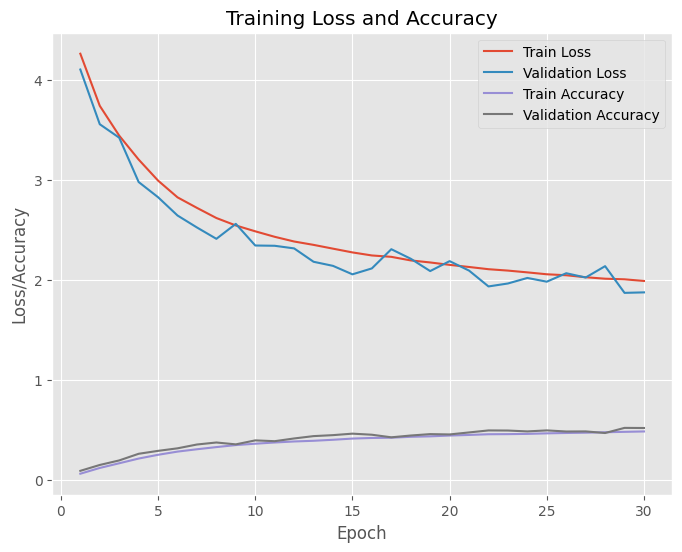

In [ ]:
# Definir el modelo
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Definir el ImageDataGenerator con data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

batch_size = 32

# Crear generador de datos para las muestras aumentadas
data_aug_factor = 2
augmented_train_gen = train_datagen.flow(x_train, y_train, batch_size=data_aug_factor * batch_size)

#Definir el modelo
inputs = keras.Input(shape=(32, 32, 3))
x1 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="swish",
            kernel_regularizer=regularizers.L2(1e-4))(inputs)
x1 = BatchNormalization()(x1)
x1 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="swish")(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Dropout(0.25)(x1)


x2 = Conv2D(filters =128, kernel_size=(3, 3), padding="same", activation="swish",
            kernel_regularizer=regularizers.L2(1e-4))(x1)
x2 = BatchNormalization()(x2)
x2 = Conv2D(filters =128, kernel_size=(3, 3), padding="same", activation="swish")(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Dropout(0.25)(x2)

x3 = Conv2D(filters = 64, kernel_size = (3, 3), padding="same", activation="swish")(x2)
x3 = BatchNormalization()(x3)
x3 = Conv2D(64, 3, 1, padding="same", activation="swish")(x3)
x3 = BatchNormalization()(x3)
x3 = MaxPooling2D(2)(x3)
x3 = Dropout(0.25)(x3)

x4 = Conv2D(filters = 32, kernel_size = (3, 3), padding="same", activation="swish")(x3)
x4 = BatchNormalization()(x4)
x4 = Conv2D(32, 3, 1, padding="same", activation="swish")(x4)
x4 = BatchNormalization()(x4)
x4 = MaxPooling2D(2)(x4)
x4 = Dropout(0.25)(x4)

xfc = Flatten()(x4)
xfc = Dense(512, activation="swish")(xfc)
xfc = (Dropout(0.25))(xfc)
xfc = Dense (256, activation="swish")(xfc)
xfc = (Dropout(0.25))(xfc)
xfc = Dense (128, activation="swish")(xfc)
xfc = BatchNormalization()(xfc)
xfc = Dropout(0.25)(xfc)

outputs = Dense(100, activation="softmax")(xfc)

conv_model = keras.Model(inputs=inputs, outputs=outputs)

conv_model.summary()

# Compilar el modelo
conv_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])


# Calcular el número de pasos de entrenamiento por época
steps_per_epoch = x_train.shape[0] // (data_aug_factor * batch_size)

# Entrenar el modelo con las muestras aumentadas
epochs = 30

H3 = conv_model.fit(
    augmented_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

# Evaluar el modelo
loss, accuracy = conv_model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

print("[INFO]: Evaluando modelo...")
predictionsconv = conv_model.predict(x_test, batch_size=32)

# Obtenemos el reporte de clasificación
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictionsconv, axis=1), target_names=labelNames))

# Mostrar gráfica de loss y accuracy
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
epochs = range(1, len(H3.history['loss']) + 1)

plt.plot(epochs, H3.history["loss"], label="Train Loss")
plt.plot(epochs, H3.history["val_loss"], label="Validation Loss")
plt.plot(epochs, H3.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, H3.history["val_accuracy"], label="Validation Accuracy")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### Modelo 7: Data Augmentation(6) (Test Loss: 1.932, Test Accuracy: 0.50)


Se crea un data augmentation de 6 imágenes. Mejora ligeramente en la perdida, pero no así en el accuracy. Además la gráfica muestra que se estaba llegando ya a aplanarse la tendencia.


Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_130 (Conv2D)         (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_147 (Ba  (None, 32, 32, 256)      1024      
 tchNormalization)                                               
                                                                 
 conv2d_131 (Conv2D)         (None, 32, 32, 256)       590080    
                                                                 
 batch_normalization_148 (Ba  (None, 32, 32, 256)      1024      
 tchNormalization)                                               
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 16, 16, 256)      0  

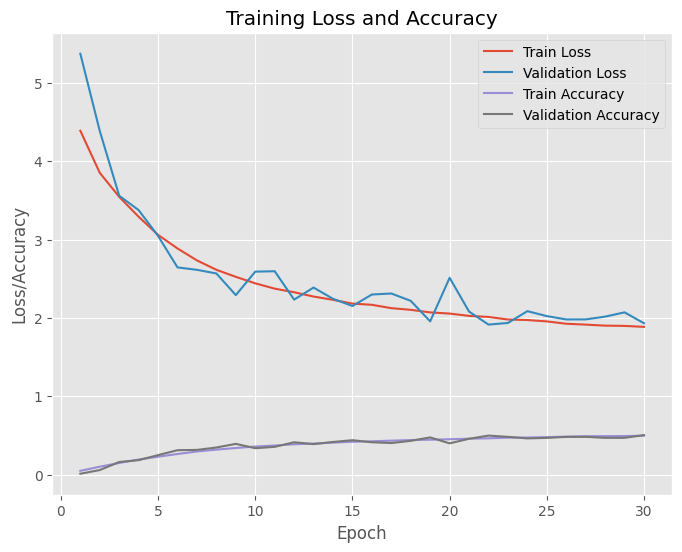

In [ ]:
# Definir el modelo
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Definir el ImageDataGenerator con data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

batch_size = 32

# Crear generador de datos para las muestras aumentadas
data_aug_factor = 6
augmented_train_gen = train_datagen.flow(x_train, y_train, batch_size=data_aug_factor * batch_size)

#Definir el modelo
inputs = keras.Input(shape=(32, 32, 3))
x1 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="swish",
            kernel_regularizer=regularizers.L2(1e-4))(inputs)
x1 = BatchNormalization()(x1)
x1 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="swish")(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Dropout(0.25)(x1)


x2 = Conv2D(filters =128, kernel_size=(3, 3), padding="same", activation="swish",
            kernel_regularizer=regularizers.L2(1e-4))(x1)
x2 = BatchNormalization()(x2)
x2 = Conv2D(filters =128, kernel_size=(3, 3), padding="same", activation="swish")(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Dropout(0.25)(x2)

x3 = Conv2D(filters = 64, kernel_size = (3, 3), padding="same", activation="swish")(x2)
x3 = BatchNormalization()(x3)
x3 = Conv2D(64, 3, 1, padding="same", activation="swish")(x3)
x3 = BatchNormalization()(x3)
x3 = MaxPooling2D(2)(x3)
x3 = Dropout(0.25)(x3)

x4 = Conv2D(filters = 32, kernel_size = (3, 3), padding="same", activation="swish")(x3)
x4 = BatchNormalization()(x4)
x4 = Conv2D(32, 3, 1, padding="same", activation="swish")(x4)
x4 = BatchNormalization()(x4)
x4 = MaxPooling2D(2)(x4)
x4 = Dropout(0.25)(x4)

xfc = Flatten()(x4)
xfc = Dense(512, activation="swish")(xfc)
xfc = (Dropout(0.25))(xfc)
xfc = Dense (256, activation="swish")(xfc)
xfc = (Dropout(0.25))(xfc)
xfc = Dense (128, activation="swish")(xfc)
xfc = BatchNormalization()(xfc)
xfc = Dropout(0.25)(xfc)

outputs = Dense(100, activation="softmax")(xfc)

conv_model = keras.Model(inputs=inputs, outputs=outputs)

conv_model.summary()

# Compilar el modelo
conv_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])


# Calcular el número de pasos de entrenamiento por época
steps_per_epoch = x_train.shape[0] // (data_aug_factor * batch_size)

# Entrenar el modelo con las muestras aumentadas
epochs = 30

H3 = conv_model.fit(
    augmented_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

# Evaluar el modelo
loss, accuracy = conv_model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

print("[INFO]: Evaluando modelo...")
predictionsconv = conv_model.predict(x_test, batch_size=32)

# Obtenemos el reporte de clasificación
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictionsconv, axis=1), target_names=labelNames))

# Mostrar gráfica de loss y accuracy
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
epochs = range(1, len(H3.history['loss']) + 1)

plt.plot(epochs, H3.history["loss"], label="Train Loss")
plt.plot(epochs, H3.history["val_loss"], label="Validation Loss")
plt.plot(epochs, H3.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, H3.history["val_accuracy"], label="Validation Accuracy")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### Modelo 7: Zoom Range de [0.9,1.25] (Test Loss: 1.93, Test Accuracy: 0.49)

De nuevo, no se muestra una mejoría ni en loss ni en accuracy, de hecho suben y a bajan respectivamente, aunque se ve que la curva baja muy rápido al inicio, y puede ser que con un número mayor de epoch pueda dar mejores resultados.
Algo muy positivo es que no hay overfitting hasta el epoch 30, lo que también muestra que puede haber mayor aprendizaje con un mayor número de entrenamientos.

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_138 (Conv2D)         (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_156 (Ba  (None, 32, 32, 256)      1024      
 tchNormalization)                                               
                                                                 
 conv2d_139 (Conv2D)         (None, 32, 32, 256)       590080    
                                                                 
 batch_normalization_157 (Ba  (None, 32, 32, 256)      1024      
 tchNormalization)                                               
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 16, 16, 256)      0  

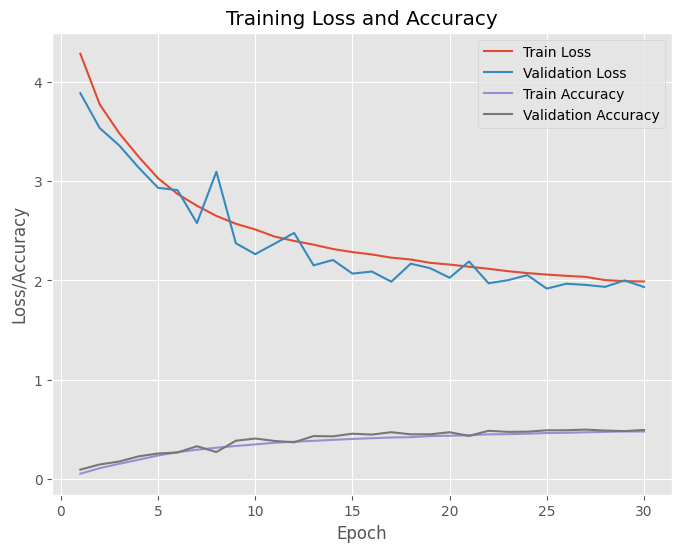

In [ ]:
# Definir el modelo
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Definir el ImageDataGenerator con data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=False,
    vertical_flip=False,
)

batch_size = 32

# Crear generador de datos para las muestras aumentadas
data_aug_factor = 2
augmented_train_gen = train_datagen.flow(x_train, y_train, batch_size=data_aug_factor * batch_size)

#Definir el modelo
inputs = keras.Input(shape=(32, 32, 3))
x1 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="swish",
            kernel_regularizer=regularizers.L2(1e-4))(inputs)
x1 = BatchNormalization()(x1)
x1 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="swish")(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Dropout(0.25)(x1)


x2 = Conv2D(filters =128, kernel_size=(3, 3), padding="same", activation="swish",
            kernel_regularizer=regularizers.L2(1e-4))(x1)
x2 = BatchNormalization()(x2)
x2 = Conv2D(filters =128, kernel_size=(3, 3), padding="same", activation="swish")(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Dropout(0.25)(x2)

x3 = Conv2D(filters = 64, kernel_size = (3, 3), padding="same", activation="swish")(x2)
x3 = BatchNormalization()(x3)
x3 = Conv2D(64, 3, 1, padding="same", activation="swish")(x3)
x3 = BatchNormalization()(x3)
x3 = MaxPooling2D(2)(x3)
x3 = Dropout(0.25)(x3)

x4 = Conv2D(filters = 32, kernel_size = (3, 3), padding="same", activation="swish")(x3)
x4 = BatchNormalization()(x4)
x4 = Conv2D(32, 3, 1, padding="same", activation="swish")(x4)
x4 = BatchNormalization()(x4)
x4 = MaxPooling2D(2)(x4)
x4 = Dropout(0.25)(x4)

xfc = Flatten()(x4)
xfc = Dense(512, activation="swish")(xfc)
xfc = (Dropout(0.25))(xfc)
xfc = Dense (256, activation="swish")(xfc)
xfc = (Dropout(0.25))(xfc)
xfc = Dense (128, activation="swish")(xfc)
xfc = BatchNormalization()(xfc)
xfc = Dropout(0.25)(xfc)

outputs = Dense(100, activation="softmax")(xfc)

conv_model = keras.Model(inputs=inputs, outputs=outputs)

conv_model.summary()

# Compilar el modelo
conv_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])


# Calcular el número de pasos de entrenamiento por época
steps_per_epoch = x_train.shape[0] // (data_aug_factor * batch_size)

# Entrenar el modelo con las muestras aumentadas
epochs = 30

H3 = conv_model.fit(
    augmented_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

# Evaluar el modelo
loss, accuracy = conv_model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

print("[INFO]: Evaluando modelo...")
predictionsconv = conv_model.predict(x_test, batch_size=32)

# Obtenemos el reporte de clasificación
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictionsconv, axis=1), target_names=labelNames))

# Mostrar gráfica de loss y accuracy
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
epochs = range(1, len(H3.history['loss']) + 1)

plt.plot(epochs, H3.history["loss"], label="Train Loss")
plt.plot(epochs, H3.history["val_loss"], label="Validation Loss")
plt.plot(epochs, H3.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, H3.history["val_accuracy"], label="Validation Accuracy")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### Modelo 7: Zoom Range + Fill_mode'reflect' (Test Loss: 1.81, Test Accuracy: 0.52)

De nuevo esta modificación no mejoró el accuracy, pero si ligeramente la pérdida. De igual manera se tiene controlado el overfitting y la tendencia es a seguir mejorando el accuracy, aunque no de manera acelerada, sin estancarse aún.

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_146 (Conv2D)         (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_165 (Ba  (None, 32, 32, 256)      1024      
 tchNormalization)                                               
                                                                 
 conv2d_147 (Conv2D)         (None, 32, 32, 256)       590080    
                                                                 
 batch_normalization_166 (Ba  (None, 32, 32, 256)      1024      
 tchNormalization)                                               
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 16, 16, 256)      0  

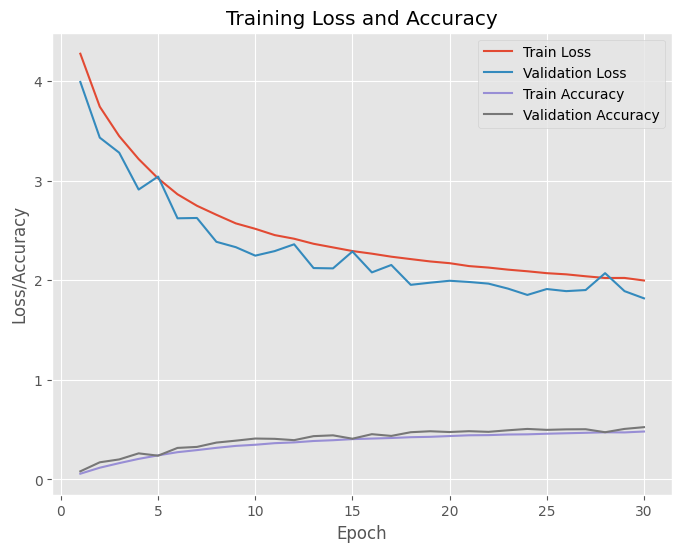

In [ ]:
# Definir el modelo
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Definir el ImageDataGenerator con data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='reflect',
)

batch_size = 32

# Crear generador de datos para las muestras aumentadas
data_aug_factor = 2
augmented_train_gen = train_datagen.flow(x_train, y_train, batch_size=data_aug_factor * batch_size)

#Definir el modelo
inputs = keras.Input(shape=(32, 32, 3))
x1 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="swish",
            kernel_regularizer=regularizers.L2(1e-4))(inputs)
x1 = BatchNormalization()(x1)
x1 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="swish")(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Dropout(0.25)(x1)


x2 = Conv2D(filters =128, kernel_size=(3, 3), padding="same", activation="swish",
            kernel_regularizer=regularizers.L2(1e-4))(x1)
x2 = BatchNormalization()(x2)
x2 = Conv2D(filters =128, kernel_size=(3, 3), padding="same", activation="swish")(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Dropout(0.25)(x2)

x3 = Conv2D(filters = 64, kernel_size = (3, 3), padding="same", activation="swish")(x2)
x3 = BatchNormalization()(x3)
x3 = Conv2D(64, 3, 1, padding="same", activation="swish")(x3)
x3 = BatchNormalization()(x3)
x3 = MaxPooling2D(2)(x3)
x3 = Dropout(0.25)(x3)

x4 = Conv2D(filters = 32, kernel_size = (3, 3), padding="same", activation="swish")(x3)
x4 = BatchNormalization()(x4)
x4 = Conv2D(32, 3, 1, padding="same", activation="swish")(x4)
x4 = BatchNormalization()(x4)
x4 = MaxPooling2D(2)(x4)
x4 = Dropout(0.25)(x4)

xfc = Flatten()(x4)
xfc = Dense(512, activation="swish")(xfc)
xfc = (Dropout(0.25))(xfc)
xfc = Dense (256, activation="swish")(xfc)
xfc = (Dropout(0.25))(xfc)
xfc = Dense (128, activation="swish")(xfc)
xfc = BatchNormalization()(xfc)
xfc = Dropout(0.25)(xfc)

outputs = Dense(100, activation="softmax")(xfc)

conv_model = keras.Model(inputs=inputs, outputs=outputs)

conv_model.summary()

# Compilar el modelo
conv_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])


# Calcular el número de pasos de entrenamiento por época
steps_per_epoch = x_train.shape[0] // (data_aug_factor * batch_size)

# Entrenar el modelo con las muestras aumentadas
epochs = 30

H3 = conv_model.fit(
    augmented_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

# Evaluar el modelo
loss, accuracy = conv_model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

print("[INFO]: Evaluando modelo...")
predictionsconv = conv_model.predict(x_test, batch_size=32)

# Obtenemos el reporte de clasificación
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictionsconv, axis=1), target_names=labelNames))

# Mostrar gráfica de loss y accuracy
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
epochs = range(1, len(H3.history['loss']) + 1)

plt.plot(epochs, H3.history["loss"], label="Train Loss")
plt.plot(epochs, H3.history["val_loss"], label="Validation Loss")
plt.plot(epochs, H3.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, H3.history["val_accuracy"], label="Validation Accuracy")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

## MODELO CON TODAS LAS IMPLEMENTACIONES

### Modelo aplicando un Kernel de 5x5 (Test Loss: 2.15, Test Accuracy: 0.48)
De nuestro modelo con Data Augmentation y todas sus implementaciones (zoom range, fill_mode = 'reflect'. se modifica el Kernel a 5x5 y un learning rate de 0.001 de igual manera se aumenta el número de epochs de 30 a 50 para conseguir tener un mayor accuracy, cuidando el overfitting.

Sin embargo no mejoró ni la tasa de pérdida ni el accuracy, y la tendencia en la gráfica era a empezar a quedarse estático el aprendizaje con un ligero overfitting.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 256)       19456     
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 256)      1024      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       1638656   
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 256)      0     

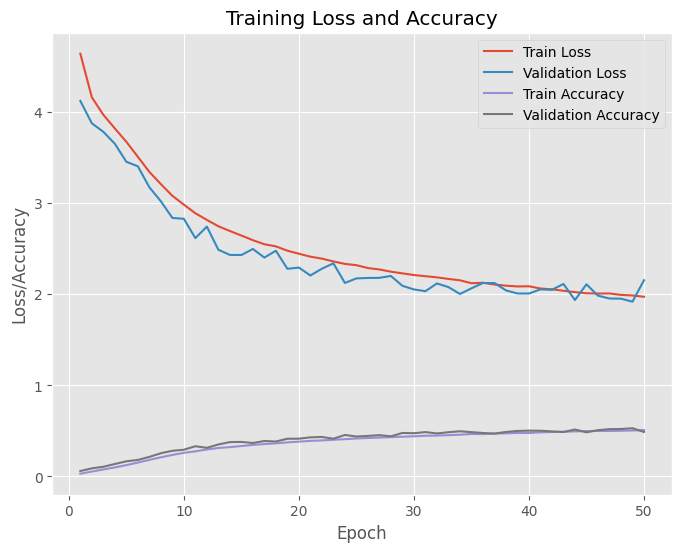

In [ ]:
# Definir el modelo
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Definir el ImageDataGenerator con data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='reflect',
)

batch_size = 32

# Crear generador de datos para las muestras aumentadas
data_aug_factor = 2
augmented_train_gen = train_datagen.flow(x_train, y_train, batch_size=data_aug_factor * batch_size)

#Definir el modelo
inputs = keras.Input(shape=(32, 32, 3))
x1 = Conv2D(filters=256, kernel_size=(5, 5), padding="same", activation="swish",
            kernel_regularizer=regularizers.L2(1e-4))(inputs)
x1 = BatchNormalization()(x1)
x1 = Conv2D(filters=256, kernel_size=(5, 5), padding="same", activation="swish")(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Dropout(0.25)(x1)


x2 = Conv2D(filters =128, kernel_size=(5, 5), padding="same", activation="swish",
            kernel_regularizer=regularizers.L2(1e-4))(x1)
x2 = BatchNormalization()(x2)
x2 = Conv2D(filters =128, kernel_size=(5, 5), padding="same", activation="swish")(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Dropout(0.25)(x2)

x3 = Conv2D(filters = 64, kernel_size = (5, 5), padding="same", activation="swish")(x2)
x3 = BatchNormalization()(x3)
x3 = Conv2D(64, 3, 1, padding="same", activation="swish")(x3)
x3 = BatchNormalization()(x3)
x3 = MaxPooling2D(2)(x3)
x3 = Dropout(0.25)(x3)

x4 = Conv2D(filters = 32, kernel_size = (5, 5), padding="same", activation="swish")(x3)
x4 = BatchNormalization()(x4)
x4 = Conv2D(32, 3, 1, padding="same", activation="swish")(x4)
x4 = BatchNormalization()(x4)
x4 = MaxPooling2D(2)(x4)
x4 = Dropout(0.50)(x4)

xfc = Flatten()(x4)
xfc = Dense(512, activation="swish")(xfc)
xfc = (Dropout(0.25))(xfc)
xfc = Dense (256, activation="swish")(xfc)
xfc = (Dropout(0.25))(xfc)
xfc = Dense (128, activation="swish")(xfc)
xfc = BatchNormalization()(xfc)
xfc = Dropout(0.50)(xfc)

outputs = Dense(100, activation="softmax")(xfc)

conv_model = keras.Model(inputs=inputs, outputs=outputs)

conv_model.summary()

opt = Adam(learning_rate=0.001)

# Compila el modelo con el optimizador definido
conv_model.compile(optimizer=opt,
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Calcular el número de pasos de entrenamiento por época
steps_per_epoch = x_train.shape[0] // (data_aug_factor * batch_size)

# Entrenar el modelo con las muestras aumentadas
epochs = 50

H3 = conv_model.fit(
    augmented_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

# Evaluar el modelo
loss, accuracy = conv_model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

print("[INFO]: Evaluando modelo...")
predictionsconv = conv_model.predict(x_test, batch_size=32)

# Obtenemos el reporte de clasificación
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictionsconv, axis=1), target_names=labelNames))

# Mostrar gráfica de loss y accuracy
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
epochs = range(1, len(H3.history['loss']) + 1)

plt.plot(epochs, H3.history["loss"], label="Train Loss")
plt.plot(epochs, H3.history["val_loss"], label="Validation Loss")
plt.plot(epochs, H3.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, H3.history["val_accuracy"], label="Validation Accuracy")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### Modelo volviendo al activation "relu"

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0   

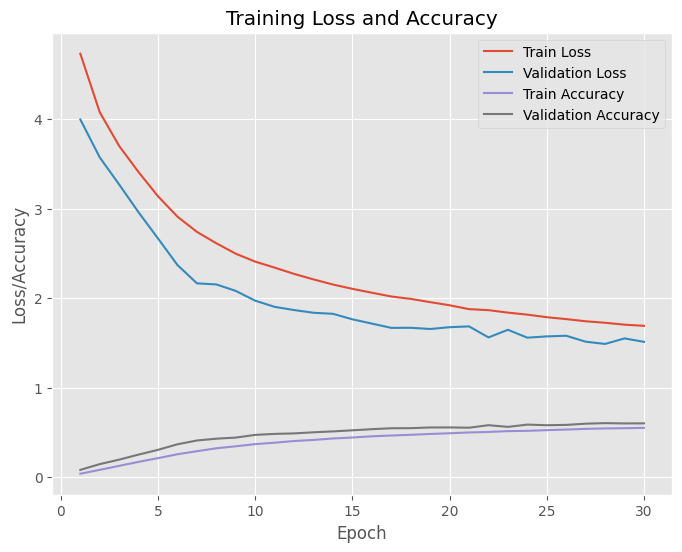

In [56]:
# Definir el modelo
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Definir el ImageDataGenerator con data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='reflect',
)

batch_size = 32

# Crear generador de datos para las muestras aumentadas
data_aug_factor = 2
augmented_train_gen = train_datagen.flow(x_train, y_train, batch_size=data_aug_factor * batch_size)

#Definir el modelo
inputs = keras.Input(shape=(32, 32, 3))
x1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu",
            kernel_regularizer=regularizers.L2(1e-4))(inputs)
x1 = BatchNormalization()(x1)
x1 = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Dropout(0.25)(x1)


x2 = Conv2D(filters =128, kernel_size=(3, 3), padding="same", activation="relu",
            kernel_regularizer=regularizers.L2(1e-4))(x1)
x2 = BatchNormalization()(x2)
x2 = Conv2D(filters =256, kernel_size=(3, 3), padding="same", activation="relu")(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Dropout(0.25)(x2)

x3 = Conv2D(filters = 256, kernel_size = (3, 3), padding="same", activation="relu")(x2)
x3 = BatchNormalization()(x3)
x3 = Conv2D(512, kernel_size=(3, 1), padding="same", activation="relu")(x3)
x3 = BatchNormalization()(x3)
x3 = MaxPooling2D(2)(x3)
x3 = Dropout(0.5)(x3)

x4 = Conv2D(filters = 512, kernel_size = (3, 3), padding="same", activation="relu")(x3)
x4 = BatchNormalization()(x4)
x4 = MaxPooling2D(2)(x4)
x4 = Dropout(0.25)(x4)

xfc = Flatten()(x4)
xfc = Dense(128, activation="relu")(xfc)
xfc = (Dropout(0.5))(xfc)
xfc = Dense (512, activation="relu")(xfc)
xfc = BatchNormalization()(xfc)
xfc = Dropout(0.5)(xfc)

outputs = Dense(100, activation="softmax")(xfc)

conv_model = keras.Model(inputs=inputs, outputs=outputs)

conv_model.summary()

opt = Adam(learning_rate=0.001)

# Compila el modelo con el optimizador definido
conv_model.compile(optimizer=opt,
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Calcular el número de pasos de entrenamiento por época
steps_per_epoch = x_train.shape[0] // (data_aug_factor * batch_size)

# Entrenar el modelo con las muestras aumentadas
epochs = 30

H3 = conv_model.fit(
    augmented_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

# Evaluar el modelo
loss, accuracy = conv_model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

print("[INFO]: Evaluando modelo...")
predictionsconv = conv_model.predict(x_test, batch_size=32)

# Obtenemos el reporte de clasificación
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictionsconv, axis=1), target_names=labelNames))

# Mostrar gráfica de loss y accuracy
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
epochs = range(1, len(H3.history['loss']) + 1)

plt.plot(epochs, H3.history["loss"], label="Train Loss")
plt.plot(epochs, H3.history["val_loss"], label="Validation Loss")
plt.plot(epochs, H3.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, H3.history["val_accuracy"], label="Validation Accuracy")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

#**CONCLUSIONES GENERALES DE LA ESTRATEGIA 2: REALIZACIÓN DE UNA CNN DESDE 0**

**Cifar 100 es un conjunto de datos complejos** y requiere de una gran cantidad de parámetros en las redes para conseguir que aprenda.

La elección de capas, en cuanto a su *número de filtros* es importante para poder generalizar y discriminar las imágenes. Se ve totalmente necesario aplicar el *parámetro "same"* para evitar perder información. De igual manera, es muy importante ir controlando en cada modelo el overfitting ya que con mucha facilidad, cuando se aumentan los filtros, el modelo empieza a memorizar.
*El overfitting* así como el aprendizaje se controlaron mediante *un mix de regularizadores, capas Maxpooling, dropout (0.5). Con todas estas medidas, junto con el ajuste a la tasa de aprendizaje parece que favoreció el control del overfitting.
Se hicieron pruebas con la activación "swish"* para conocer si con la popularidad que demuestra en las redes también mejoraba nuestro modelo, pero no notamos una gran diferencia.
Con todo esto, utilizar el *Data Augmentation, combinado con el zoom y el fill_mode 'reflect*' de lo que se había perdido de accuracy por cuiddar el overfitting, ayudó a *mejorar las pérdidas y el accuracy*, pero no es suficiente para conseguir un accuracy mayor.

En las últimas pruebas finales del modelo con todas las implementaciones se decide hacer una última prueba con un kernel 5x5 y un **número mayor de epoch** para corroborar que debido a la complejidad de Cifar 100, es necesario este aumento para conseguir un mayor accuracy.
No hemos tenido el éxito esperado.


Hay muchas modificaciones más que podríamos hacer, y se realizaron entre el equipo, sin embargo crear un modelo desde cero requiere de mucho mayor experimentación. Es probable también que debido a la complejidad y como vimos en la prueba del modelo 3, poner epochs mucho mayores (300), tendríamos mejores resultados. Sin embargo **el gasto en tiempo y recursos es demasiado alto.**